### 1. Carga de los dataframes filtrados
Se cargan los datos que se filtraron previamente para incluir solo el periodo del 01-01-2023 al 30-06-2023. Tambien se cargan las librerias que se utilziaran en el trabajo

In [400]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import  seaborn as sns
import matplotlib.dates as mdates
import folium
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap

In [401]:
df_station_list = pd.read_csv('./dfs_Bikeshare_2023/station_list.csv')
df_usage_freq = pd.read_csv('./usage_freq_2023_fullyear.csv')
df_daily_rents = pd.read_csv('./df_daily_rents_2023_fullyear.csv')
df_weather = pd.read_csv('./weather_2023_fullyear.csv')

### 2. Limpieza de los df

#### 2.1. Station list
&nbsp;&nbsp;&nbsp;&nbsp;Contiene un listado de la dirección de cada una de las estaciones.

In [402]:
df_station_list.head()

,station_id,station_name
0,30200,9th St & Pennsylvania Ave NW
1,30201,9th & G St NW
2,31000,Eads St & 15th St S
3,31001,18th St & S Eads St
4,31002,Crystal Dr & 20th St S


In [403]:
df_station_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   station_id    916 non-null    int64 
 1   station_name  916 non-null    object
dtypes: int64(1), object(1)
memory usage: 14.4+ KB


#### 2.2. Daily rents
&nbsp;&nbsp;&nbsp;&nbsp;Contiene información sobre cada uno de los alquileres realizados

In [404]:
df_daily_rents.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,65F0ACD101BF0D49,classic_bike,2023-01-04 19:34:07,2023-01-04 19:39:29,East Falls Church Metro / Sycamore St & 19th St N,31904.0,W Columbia St & N Washington St,32609.0,38.885321,-77.156427,38.885621,-77.166917,member
1,D75158CE73DC43F0,classic_bike,2023-01-27 15:26:38,2023-01-27 19:21:36,Carroll & Westmoreland Ave,32025.0,Fenton St & Ellsworth Dr,32036.0,38.975000,-77.011210,38.997033,-77.025608,member
2,33E85889625FF7CA,classic_bike,2023-01-05 20:44:38,2023-01-05 20:51:18,15th & L St NW,31276.0,Thomas Circle,31241.0,38.903649,-77.034918,38.905900,-77.032500,member
3,E1F055A1651F47A1,classic_bike,2023-01-03 17:45:14,2023-01-03 17:57:23,Hartland Rd & Harte Pl,32255.0,Merrifield Cinema & Merrifield Town Center,32235.0,38.878601,-77.222808,38.870093,-77.229970,member
4,88CC90CEEC298BAF,classic_bike,2023-01-03 05:18:46,2023-01-03 05:25:50,Merrifield Cinema & Merrifield Town Center,32235.0,Hartland Rd & Harte Pl,32255.0,38.870093,-77.229970,38.878601,-77.222808,member


In [405]:
# pasar a formato datetime las columnas de fecha de inicio y fin de trayecto
df_daily_rents['started_at'] = pd.to_datetime(df_daily_rents['started_at'])
df_daily_rents['ended_at'] = pd.to_datetime(df_daily_rents['ended_at'])

#  pasar a integer los id de las estaciones
df_daily_rents['start_station_id'] = pd.to_numeric(df_daily_rents['start_station_id'], errors = 'coerce').astype('Int64')
df_daily_rents['end_station_id'] = pd.to_numeric(df_daily_rents['end_station_id'],errors =  'coerce').astype('Int64')

In [406]:
df_daily_rents.info()  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4467275 entries, 0 to 4467274
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    Int64         
 6   end_station_name    object        
 7   end_station_id      Int64         
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
dtypes: Int64(2), datetime64[ns](2), float64(4), object(5)
memory usage: 451.6+ MB


In [407]:
# La columna duration es la duración total del viaje en minutos, calculada restando la hora de final menos la de inicio del viaje
df_daily_rents['duration'] = (df_daily_rents['ended_at'] - df_daily_rents['started_at']).dt.total_seconds() / 60      # total_seconds convierte el resultado a segundos y dividiendo entre 60 se obtienen minutos
df_daily_rents

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration
0,65F0ACD101BF0D49,classic_bike,2023-01-04 19:34:07,2023-01-04 19:39:29,East Falls Church Metro / Sycamore St & 19th St N,31904,W Columbia St & N Washington St,32609,38.885321,-77.156427,38.885621,-77.166917,member,5.366667
1,D75158CE73DC43F0,classic_bike,2023-01-27 15:26:38,2023-01-27 19:21:36,Carroll & Westmoreland Ave,32025,Fenton St & Ellsworth Dr,32036,38.975000,-77.011210,38.997033,-77.025608,member,234.966667
2,33E85889625FF7CA,classic_bike,2023-01-05 20:44:38,2023-01-05 20:51:18,15th & L St NW,31276,Thomas Circle,31241,38.903649,-77.034918,38.905900,-77.032500,member,6.666667
3,E1F055A1651F47A1,classic_bike,2023-01-03 17:45:14,2023-01-03 17:57:23,Hartland Rd & Harte Pl,32255,Merrifield Cinema & Merrifield Town Center,32235,38.878601,-77.222808,38.870093,-77.229970,member,12.150000
4,88CC90CEEC298BAF,classic_bike,2023-01-03 05:18:46,2023-01-03 05:25:50,Merrifield Cinema & Merrifield Town Center,32235,Hartland Rd & Harte Pl,32255,38.870093,-77.229970,38.878601,-77.222808,member,7.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4467270,68A1AA2C614921C4,classic_bike,2023-12-16 00:08:39,2023-12-16 00:16:30,11th & S St NW,31280,17th & P St NW,31330,38.913601,-77.027115,38.909858,-77.038566,member,7.850000
4467271,25C0FB40A035EA7C,classic_bike,2023-12-06 18:23:32,2023-12-06 18:27:26,Eastern Market / 7th & North Carolina Ave SE,31610,Massachusetts Ave & 6th St NE,31657,38.886952,-76.996806,38.892934,-76.998273,member,3.900000
4467272,969BD21B0E2F499A,electric_bike,2023-12-09 17:47:53,2023-12-09 18:03:16,8th & D St NW,31270,16th & R St NW,31282,38.894771,-77.023308,38.912652,-77.036278,casual,15.383333
4467273,DEA9A4BA005B1A26,electric_bike,2023-12-09 18:14:52,2023-12-09 18:25:48,5th & F St NW,31620,Lincoln Rd & Seaton Pl NE/Harry Thomas Rec Center,31523,38.897282,-77.019359,38.915000,-77.007800,casual,10.933333


In [409]:
df_daily_rents[df_daily_rents['duration'] < 0]       

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration
25585,631B8361A74C07D1,electric_bike,2023-01-30 08:24:31,2023-01-30 08:22:00,NaN,<NA>,5th & K St NW,31600,38.900000,-77.020000,38.903040,-77.019027,member,-2.516667
35562,18767473F78A7C81,classic_bike,2023-01-11 08:51:55,2023-01-11 08:50:32,Convention Center / 7th & M St NW,31223,Convention Center / 7th & M St NW,31223,38.905737,-77.022270,38.905737,-77.022270,member,-1.383333
207134,3FEDCD9A4D6C7A85,classic_bike,2023-02-19 17:56:26,2023-02-19 17:56:25,5th & K St NW,31600,5th & K St NW,31600,38.903040,-77.019027,38.903040,-77.019027,member,-0.016667
318650,D8CF74DA1DAE4D9B,electric_bike,2023-02-14 19:26:12,2023-02-14 19:21:35,NaN,<NA>,12th & L St NW,31251,38.900000,-77.030000,38.903819,-77.028400,member,-4.616667
341607,C5E2D3B25F96AB2D,electric_bike,2023-02-28 15:07:27,2023-02-28 15:04:59,NaN,<NA>,11th & Park Rd NW,31651,38.930000,-77.030000,38.931322,-77.028247,member,-2.466667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4422830,2CC520F73A4017DF,electric_bike,2023-12-30 17:52:51,2023-12-30 17:52:45,NaN,<NA>,NaN,<NA>,38.900000,-76.990000,38.900000,-76.990000,casual,-0.100000
4427417,FC956737F0CC833D,electric_bike,2023-12-13 19:09:48,2023-12-13 19:09:45,NaN,<NA>,NaN,<NA>,38.910000,-77.060000,38.910000,-77.060000,member,-0.050000
4432453,6564E3AE8393A8E7,electric_bike,2023-12-29 14:59:03,2023-12-29 14:58:53,NaN,<NA>,NaN,<NA>,38.970000,-77.030000,38.970000,-77.030000,member,-0.166667
4432993,783A80D51A81FAB5,electric_bike,2023-12-07 20:57:30,2023-12-07 20:57:21,NaN,<NA>,NaN,<NA>,38.900000,-77.030000,38.900000,-77.030000,member,-0.150000


Vemos que hay 161 filas que tienen  una duración negativa.  Esto no tiene sentido, por lo que se eliminan. 
También se van a eliminar los viajes de duración menor a 2 minutos ya que se considera que pueden ser errores a la hora de desbloqueo de la bici y los de duración mayor a 2 horas, que pueden ser bicis extraviadas o que no se devuelven correctamente en la estación.

In [410]:
df_daily_rents.drop(df_daily_rents[(df_daily_rents['duration'] < 2) | (df_daily_rents['duration'] > 120)].index, inplace=True)   #Eliminamos las filas identificadas en la celda de arriba
df_daily_rents.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4240884 entries, 0 to 4467274
Data columns (total 14 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    Int64         
 6   end_station_name    object        
 7   end_station_id      Int64         
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
 13  duration            float64       
dtypes: Int64(2), datetime64[ns](2), float64(5), object(5)
memory usage: 493.4+ MB


Se comprueba si existen valores nulos en alguna de las columnas:

In [411]:
for i in range(df_daily_rents.shape[1]):    
    print(f"Column {i}: {df_daily_rents.iloc[:, i].isnull().sum()} nulos")  


Column 0: 0 nulos
Column 1: 0 nulos
Column 2: 0 nulos
Column 3: 0 nulos
Column 4: 360082 nulos
Column 5: 360082 nulos
Column 6: 372262 nulos
Column 7: 372262 nulos
Column 8: 0 nulos
Column 9: 0 nulos
Column 10: 243 nulos
Column 11: 243 nulos
Column 12: 0 nulos
Column 13: 0 nulos


Comprobamos que los nulos de las columnas end_lat y end_long están en las mismas líneas:

In [412]:
coordenadas_end_nulas = df_daily_rents[(df_daily_rents['end_lat'].isnull()) | (df_daily_rents['end_lng'].isnull())]      
coordenadas_end_nulas 

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration
13257,9A804CA87D582830,docked_bike,2023-01-02 15:32:56,2023-01-02 16:04:04,Jefferson Dr & 14th St SW,31247,NaN,<NA>,38.888553,-77.032427,NaN,NaN,casual,31.133333
13288,30E9B447470BB81C,docked_bike,2023-01-02 15:35:51,2023-01-02 16:08:31,Jefferson Dr & 14th St SW,31247,NaN,<NA>,38.888553,-77.032427,NaN,NaN,casual,32.666667
78350,C29C1680751747F8,docked_bike,2023-01-05 12:34:05,2023-01-05 13:52:48,10th & E St NW,31256,NaN,<NA>,38.895914,-77.026064,NaN,NaN,casual,78.716667
99041,7A7D4103611CE988,docked_bike,2023-01-02 15:36:35,2023-01-02 16:04:04,Jefferson Dr & 14th St SW,31247,NaN,<NA>,38.888553,-77.032427,NaN,NaN,casual,27.483333
99072,AF3C4ED45B43505E,docked_bike,2023-01-10 17:55:04,2023-01-10 19:24:05,Columbus Circle / Union Station,31623,NaN,<NA>,38.896960,-77.004930,NaN,NaN,casual,89.016667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3266212,FAFBC95513DB32CF,docked_bike,2023-09-05 09:28:30,2023-09-05 10:39:59,Massachusetts Ave & Dupont Circle NW,31200,NaN,<NA>,38.910100,-77.044400,NaN,NaN,casual,71.483333
3266420,2699B3533D19723E,docked_bike,2023-09-12 08:27:49,2023-09-12 09:22:55,Metro Center / 12th & G St NW,31230,NaN,<NA>,38.898326,-77.027959,NaN,NaN,casual,55.100000
3267275,B0EA693758876D5A,docked_bike,2023-09-12 08:27:52,2023-09-12 09:22:55,Metro Center / 12th & G St NW,31230,NaN,<NA>,38.898326,-77.027959,NaN,NaN,casual,55.050000
3274554,A9B2403CD17E249D,docked_bike,2023-09-03 11:41:17,2023-09-03 12:32:30,M St & Pennsylvania Ave NW,31246,NaN,<NA>,38.905126,-77.056887,NaN,NaN,casual,51.216667


In [413]:
print(coordenadas_end_nulas['end_station_name'].unique())
print(coordenadas_end_nulas['end_station_id'].unique())

[nan]
<IntegerArray>
[<NA>]
Length: 1, dtype: Int64


Tras comprobar en los dos pasos anteriores que las 192 celdas que no contienen datos de coordenadas de final de trayecto, tampoco tienen datos de nombre o id de la estación, vamos a eliminarlos.

In [414]:
df_daily_rents.drop(coordenadas_end_nulas.index, inplace = True)                # Eliminamos y comprobamos que ya no están esos valores nulos.
for i in range(df_daily_rents.shape[1]):    
    print(f"Column {i}: {df_daily_rents.iloc[:, i].isnull().sum()} nulos")  

Column 0: 0 nulos
Column 1: 0 nulos
Column 2: 0 nulos
Column 3: 0 nulos
Column 4: 360082 nulos
Column 5: 360082 nulos
Column 6: 372019 nulos
Column 7: 372019 nulos
Column 8: 0 nulos
Column 9: 0 nulos
Column 10: 0 nulos
Column 11: 0 nulos
Column 12: 0 nulos
Column 13: 0 nulos


Sigue habiendo valores nulos en las columnas de nombre e id de la estación de inicio y final. Pero como tenemos las coordenadas en todos los viajes, se puede intentar rellenar esos datos

In [415]:
df_station_list = df_daily_rents.groupby(['start_station_id', 'start_station_name'])[['start_station_id', 'start_station_name','start_lat', 'start_lng']].agg({
    'start_lat': 'mean',
    'start_lng': 'mean'
}).reset_index()

df_station_list.rename(columns = {'start_station_id': 'station_id', 'start_station_name':'station_name',  'start_lat':'lat', 'start_lng':'lng'}, inplace = True)
df_station_list


,station_id,station_name,lat,lng
0,30200,9th St & Pennsylvania Ave NW,38.894271,-77.023982
1,30201,9th & G St NW,38.898121,-77.023941
2,31000,Eads St & 15th St S,38.859198,-77.053221
3,31002,Crystal Dr & 20th St S,38.856425,-77.049230
4,31003,Crystal Dr & 15th St S,38.861043,-77.049417
...,...,...,...,...
789,32607,S Maple Ave & S Washington St,38.879732,-77.178398
790,32608,Falls Church City Hall / Park Ave & Little Fal...,38.885436,-77.173591
791,32609,W Columbia St & N Washington St,38.885624,-77.166920
792,32901,6035 Warehouse,38.963528,-77.010702


In [416]:
print(df_station_list['station_name'].nunique())      # Vemos que hay station_id que tienen distinto station_name
print(df_station_list['station_id'].nunique())


792
766


In [417]:
# Crear la máscara para filas con start_station_id duplicado
mascara_duplicados = df_station_list['station_id'].duplicated(keep=False)

# Mostrar las filas donde start_station_id está duplicado
df_duplicados = df_station_list[mascara_duplicados]

# Ordenar el resultado por start_station_id para una mejor visualización
df_duplicados = df_duplicados.sort_values('station_id')

df_duplicados

,station_id,station_name,lat,lng
51,31051,12th St N & N Pierce St,38.887659,-77.075902
52,31051,Arlington Blvd & N Queen St,38.889362,-77.077295
97,31096,Columbia Pike & S Highland St,38.862393,-77.089116
98,31096,Walter Reed Dr & 8th St S,38.866129,-77.087871
110,31109,7th & T St NW,38.915687,-77.021698
111,31109,7th St & Florida Ave NW,38.916144,-77.022022
144,31203,14th & Rhode Island Ave NW,38.908597,-77.032304
145,31203,14th St & Rhode Island Ave NW,38.908606,-77.032317
162,31220,21st & E St NW,38.896159,-77.046624
163,31220,21st NW & E St NW,38.896114,-77.046615


Las columnas de la celda anterior son las que tienen distinto name para el mismo id. Al no ser muchas, añadiremos en los Nan del df inicial solo uno de los dos nombres ya que el error será pequeño

In [418]:
# Eliminar los duplicados
df_station_list = df_station_list.drop_duplicates(subset='station_id', keep='first')
df_station_list.info()

<class 'pandas.core.frame.DataFrame'>
Index: 766 entries, 0 to 793
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   station_id    766 non-null    Int64  
 1   station_name  766 non-null    object 
 2   lat           766 non-null    float64
 3   lng           766 non-null    float64
dtypes: Int64(1), float64(2), object(1)
memory usage: 30.7+ KB


Ahora se van a rellenar los Nan de start_station_id y end_station_id buscando por coordenadas de la estacion en df_station_list

In [419]:
'''
def encontrar_coincidencia(row, df_ref, umbral=0.0001):
    # Encontrar filas en df_ref que estén dentro del umbral para ambas coordenadas
    coincidencias = df_ref[
        (abs(df_ref['lat'] - row['start_lat']) < umbral) &
        (abs(df_ref['lng'] - row['start_lng']) < umbral)
    ]
    
    if not coincidencias.empty:
        # Si hay coincidencias, tomar la primera
        return coincidencias.iloc[0]
    return row

# Aplicar la función para rellenar valores NaN
df_daily_rents = df_daily_rents.apply(
    lambda row: encontrar_coincidencia(row, df_station_list)
    if pd.isna(row['start_station_id']) or pd.isna(row['start_station_name']) 
    else row, axis=1)

df_daily_rents.info()
'''

"\ndef encontrar_coincidencia(row, df_ref, umbral=0.0001):\n    # Encontrar filas en df_ref que estén dentro del umbral para ambas coordenadas\n    coincidencias = df_ref[\n        (abs(df_ref['lat'] - row['start_lat']) < umbral) &\n        (abs(df_ref['lng'] - row['start_lng']) < umbral)\n    ]\n    \n    if not coincidencias.empty:\n        # Si hay coincidencias, tomar la primera\n        return coincidencias.iloc[0]\n    return row\n\n# Aplicar la función para rellenar valores NaN\ndf_daily_rents = df_daily_rents.apply(\n    lambda row: encontrar_coincidencia(row, df_station_list)\n    if pd.isna(row['start_station_id']) or pd.isna(row['start_station_name']) \n    else row, axis=1)\n\ndf_daily_rents.info()\n"

Como el proceso de rellenar valores es muy lento (30-60 minutos), se van a eliminar las filas que contienen Nan, ya que el df sigue siendo suficientemente grande

In [420]:
df_daily_rents.drop(df_daily_rents[(df_daily_rents['start_station_id'].isnull()) | 
                                   (df_daily_rents['start_station_name'].isnull()) | 
                                   (df_daily_rents['end_station_id'].isnull()) | 
                                   (df_daily_rents['end_station_name'].isnull())].index, inplace = True)                # Eliminamos y comprobamos que ya no están esos valores nulos.
for i in range(df_daily_rents.shape[1]):    
    print(f"Column {i}: {df_daily_rents.iloc[:, i].isnull().sum()} nulos")  

Column 0: 0 nulos
Column 1: 0 nulos
Column 2: 0 nulos
Column 3: 0 nulos
Column 4: 0 nulos
Column 5: 0 nulos
Column 6: 0 nulos
Column 7: 0 nulos
Column 8: 0 nulos
Column 9: 0 nulos
Column 10: 0 nulos
Column 11: 0 nulos
Column 12: 0 nulos
Column 13: 0 nulos


In [421]:
df_daily_rents.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3706293 entries, 0 to 4467274
Data columns (total 14 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    Int64         
 6   end_station_name    object        
 7   end_station_id      Int64         
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
 13  duration            float64       
dtypes: Int64(2), datetime64[ns](2), float64(5), object(5)
memory usage: 431.2+ MB


#### 2.3. Usage frequency
&nbsp;&nbsp;&nbsp;&nbsp;Usage freq contiene la cantidad de pickups y dropoffs que se realizan en cada estación cada día. Como se han eliminado en daily_rents algunos alquileres, se va a calcular esta tabla nuevamente a partir de la info actualizada de daily_rents.


In [422]:
# Creamos en df_daily_rents una columna con la fecha de comienzo y otra con la fecha de final del alquiler sin la hora
df_daily_rents['start_date'] = pd.to_datetime(df_daily_rents['started_at'].dt.date)
df_daily_rents['end_date'] = pd.to_datetime(df_daily_rents['ended_at'].dt.date)

# A continuación agrupamos por estación fecha de inicio y por fecha de fin y sumamos los dos df
df_pickups = df_daily_rents.groupby(['start_date', 'start_station_name']).size().reset_index(name='pickup_counts')
df_dropoffs = df_daily_rents.groupby(['end_date', 'end_station_name']).size().reset_index(name='dropoff_counts')

# Combinamos los dos df creados en el paso anterior
df_usage_freq = pd.merge(df_pickups, df_dropoffs, 
                       left_on=['start_date', 'start_station_name'], 
                       right_on=['end_date', 'end_station_name'], 
                       how='outer')
df_usage_freq = df_usage_freq.drop(['end_date', 'end_station_name'], axis=1)
df_usage_freq.rename( columns ={'start_date': 'date','start_station_name': 'station_name'}, inplace=True)

# Rellenamos los valores NaN con 0
df_usage_freq['pickup_counts'] = df_usage_freq['pickup_counts'].fillna(0)
df_usage_freq['dropoff_counts'] = df_usage_freq['dropoff_counts'].fillna(0)

# Pasamos date a formato datetime
df_usage_freq['date'] = pd.to_datetime(df_usage_freq['date'])

df_usage_freq


,date,station_name,pickup_counts,dropoff_counts
0,2023-01-01,10th & E St NW,17.0,26.0
1,2023-01-01,10th & G St NW,11.0,18.0
2,2023-01-01,10th & H St NE,17.0,14.0
3,2023-01-01,10th & K St NW,29.0,22.0
4,2023-01-01,10th & Monroe St NE,4.0,1.0
...,...,...,...,...
226792,2023-12-31,Wisconsin Ave & Upton St NW,1.0,3.0
226793,2023-12-31,Woodglen Dr & Executive Blvd,1.0,3.0
226794,2023-12-31,Woodley Park Metro / Calvert St & Connecticut ...,22.0,17.0
226795,2023-12-31,Woodmont Ave & Strathmore St,6.0,5.0


#### 2.4. Weather
&nbsp;&nbsp;&nbsp;&nbsp;Contiene información relativa a las condiciones climáticas de cada día en la ciudad de Washington

In [423]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   datetime          365 non-null    object 
 1   name              365 non-null    object 
 2   tempmax           365 non-null    float64
 3   tempmin           365 non-null    float64
 4   temp              365 non-null    float64
 5   feelslikemax      365 non-null    float64
 6   feelslikemin      365 non-null    float64
 7   feelslike         365 non-null    float64
 8   dew               365 non-null    float64
 9   humidity          365 non-null    float64
 10  precip            365 non-null    float64
 11  precipprob        365 non-null    int64  
 12  precipcover       365 non-null    float64
 13  preciptype        179 non-null    object 
 14  snow              365 non-null    float64
 15  snowdepth         365 non-null    float64
 16  windgust          365 non-null    float64
 1

In [424]:
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])

La tabla weather contiene información muy detallada. A continuación se van a eliminar algunas columnas que no se van a utilizar en este análisis

In [425]:
df_weather.drop(columns= ['dew', 'humidity', 'sealevelpressure', 'cloudcover', 'visibility', 'winddir', 'solarradiation','solarenergy', 'severerisk', 'sunrise', 'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations', 'preciptype', 'precipprob' ],
                 inplace = True)
df_weather

,datetime,name,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,precip,precipcover,snow,snowdepth,windgust,windspeed,uvindex
0,2023-01-01,"Washington,DC,USA",16.3,6.4,11.0,16.3,5.4,10.7,0.101,4.17,0.0,0.0,22.3,14.2,4
1,2023-01-02,"Washington,DC,USA",17.2,4.4,10.5,17.2,2.4,10.1,0.000,0.00,0.0,0.0,16.6,14.7,4
2,2023-01-03,"Washington,DC,USA",20.0,10.1,15.2,20.0,10.1,15.2,0.000,0.00,0.0,0.0,47.1,28.5,2
3,2023-01-04,"Washington,DC,USA",18.3,11.9,15.3,18.3,11.9,15.3,0.000,0.00,0.0,0.0,50.0,22.8,2
4,2023-01-05,"Washington,DC,USA",17.8,9.8,13.5,17.8,7.3,13.3,0.000,0.00,0.0,0.0,22.3,20.2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2023-12-27,"Washington,DC,USA",13.4,8.3,10.2,13.4,5.7,9.2,26.626,87.50,0.0,0.0,33.5,16.1,1
361,2023-12-28,"Washington,DC,USA",13.8,10.6,11.8,13.8,10.6,11.8,1.043,25.00,0.0,0.0,29.5,16.0,2
362,2023-12-29,"Washington,DC,USA",12.2,7.8,10.0,12.2,4.8,9.1,0.000,0.00,0.0,0.0,43.8,25.9,4
363,2023-12-30,"Washington,DC,USA",9.9,2.8,6.9,7.8,0.3,4.4,0.000,0.00,0.0,0.0,50.0,27.8,3


A continuación se explica el contenido de cada columna de la tabla:
- **name**: location
- **datetime**: date
- **tempmax**: maximum temperature at the location.
- **tempmin**: minimum temperature at the location.
- **temp**: temperature at the location. Daily values are average values (mean) for the day.
- **feelslikemax**: maximum feels like temperature at the location.
- **feelslikemin**: minimum feels like temperature at the location.
- **feelslike**: what the temperature feels like accounting for heat index or wind chill. Daily values are average values (mean) for the day.
- **precip**: the amount of liquid precipitation that fell or is predicted to fall in the period.
- **precipprob**: 100 % if it rained, 0% if not
- **precipcover**: the proportion of hours where there was non-zero precipitation
- **snow**: the amount of snow that fell or is predicted to fall
- **snowdepth**: the depth of snow on the ground
- **windgust**: instantaneous wind speed at a location
- **windspeed**: the sustained wind speed measured as the average windspeed that occurs during the preceding one to two minutes. Daily values are the maximum hourly value for the day.
- **uvindex**: a value between 0 and 10 indicating the level of ultra violet (UV) exposure for that day.

In [426]:
df_weather.set_index('datetime')

,name,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,precip,precipcover,snow,snowdepth,windgust,windspeed,uvindex
datetime,,,,,,,,,,,,,,
2023-01-01,"Washington,DC,USA",16.3,6.4,11.0,16.3,5.4,10.7,0.101,4.17,0.0,0.0,22.3,14.2,4
2023-01-02,"Washington,DC,USA",17.2,4.4,10.5,17.2,2.4,10.1,0.000,0.00,0.0,0.0,16.6,14.7,4
2023-01-03,"Washington,DC,USA",20.0,10.1,15.2,20.0,10.1,15.2,0.000,0.00,0.0,0.0,47.1,28.5,2
2023-01-04,"Washington,DC,USA",18.3,11.9,15.3,18.3,11.9,15.3,0.000,0.00,0.0,0.0,50.0,22.8,2
2023-01-05,"Washington,DC,USA",17.8,9.8,13.5,17.8,7.3,13.3,0.000,0.00,0.0,0.0,22.3,20.2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,"Washington,DC,USA",13.4,8.3,10.2,13.4,5.7,9.2,26.626,87.50,0.0,0.0,33.5,16.1,1
2023-12-28,"Washington,DC,USA",13.8,10.6,11.8,13.8,10.6,11.8,1.043,25.00,0.0,0.0,29.5,16.0,2
2023-12-29,"Washington,DC,USA",12.2,7.8,10.0,12.2,4.8,9.1,0.000,0.00,0.0,0.0,43.8,25.9,4


In [427]:
for i in range(df_weather.shape[1]):    
    print(f"Column {i}: {df_weather.iloc[:, i].isnull().sum()} nulos")  

Column 0: 0 nulos
Column 1: 0 nulos
Column 2: 0 nulos
Column 3: 0 nulos
Column 4: 0 nulos
Column 5: 0 nulos
Column 6: 0 nulos
Column 7: 0 nulos
Column 8: 0 nulos
Column 9: 0 nulos
Column 10: 0 nulos
Column 11: 0 nulos
Column 12: 0 nulos
Column 13: 0 nulos
Column 14: 0 nulos


### 3. Análisis univariante

#### 3.1. Análisis del uso de bicicletas

##### 3.1.1. Tendencia de la demanda de alquiler de bicicletas

Calculamos el total de alquileres y devoluciones por día y lo visualizamos

In [428]:
total_rents_per_day = df_usage_freq.groupby('date')[['pickup_counts', 'dropoff_counts']].sum()
total_rents_per_day

,pickup_counts,dropoff_counts
date,,
2023-01-01,5972.0,5899.0
2023-01-02,6462.0,6421.0
2023-01-03,6811.0,6770.0
2023-01-04,7005.0,6965.0
2023-01-05,7625.0,7567.0
...,...,...
2023-12-27,1708.0,1608.0
2023-12-28,5903.0,5839.0
2023-12-29,6364.0,6323.0


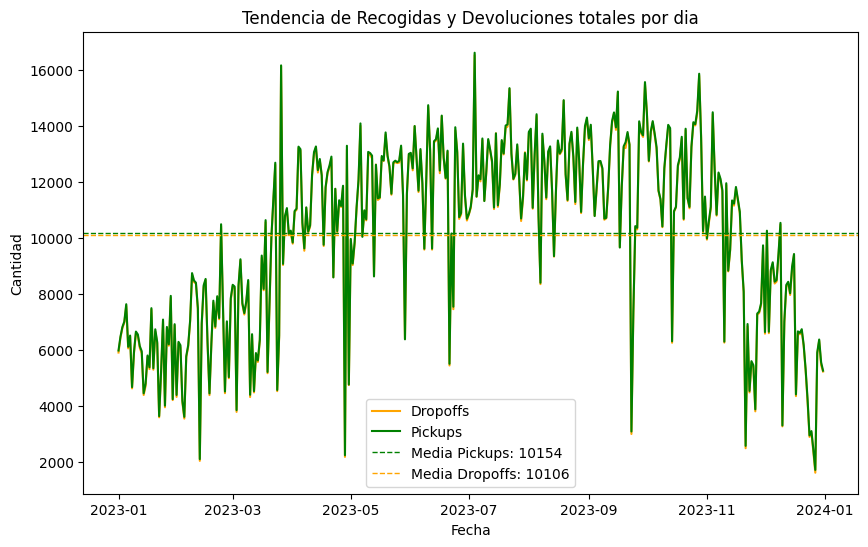

In [498]:
plt.figure(figsize=(10, 6))

plt.plot(total_rents_per_day.index, total_rents_per_day['dropoff_counts'], label='Dropoffs', color='orange', linestyle = '-')
plt.plot(total_rents_per_day.index, total_rents_per_day['pickup_counts'], label='Pickups', color='green', linestyle = '-')

# Calcula la media de 'pickup_counts' y 'dropoff_counts'
pickup_mean = total_rents_per_day['pickup_counts'].mean()
dropoff_mean = total_rents_per_day['dropoff_counts'].mean()
# Añade líneas de la media
plt.axhline(y=pickup_mean, color='green', linestyle='--', linewidth=1, label=f'Media Pickups: {int(pickup_mean)}')
plt.axhline(y=dropoff_mean, color='orange', linestyle='--', linewidth=1, label=f'Media Dropoffs: {int(dropoff_mean)}')

plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.title('Tendencia de Recogidas y Devoluciones totales por dia')
plt.show()



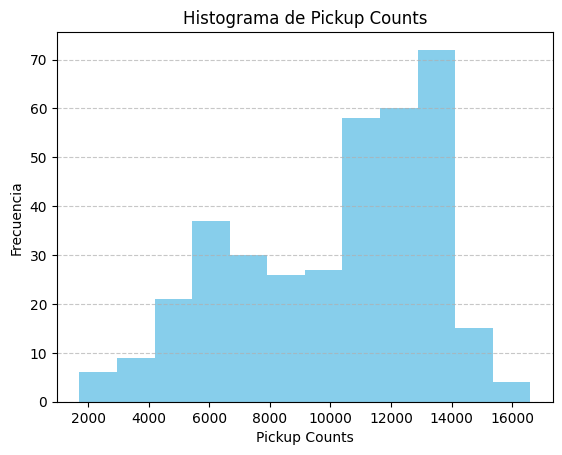

In [430]:
plt.hist(total_rents_per_day['pickup_counts'], bins =12, color = 'skyblue')
plt.title("Histograma de Pickup Counts")
plt.xlabel("Pickup Counts")
plt.ylabel("Frecuencia")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

##### 3.1.2 Duración de los trayectos y tendencias horarias de uso

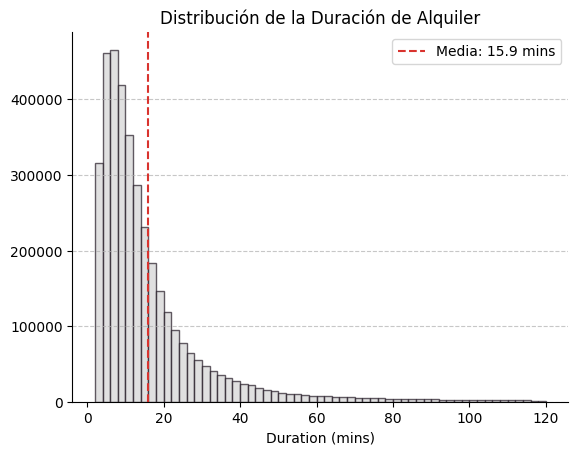

In [431]:
df_daily_rents.hist(column = 'duration', bins = 59, color="#d3d3d3", edgecolor='#221824', alpha=0.7, grid=False)
# Etiquetas y título
plt.xlabel('Duration (mins)')
plt.ylabel('')
plt.title('Distribución de la Duración de Alquiler')

# Calcula la media de la duración
mean_duration = df_daily_rents['duration'].mean()
# Añade una línea vertical en la media
plt.axvline(mean_duration, color='#d9332e', linestyle='--', linewidth=1.5, label=f'Media: {mean_duration:.1f} mins')
plt.legend()

# Ocultar el recuadro (spines)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


# Agregar una cuadrícula para facilitar la interpretación
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [432]:
df_daily_rents['duration'].describe() 

count    3.706293e+06
mean     1.593962e+01
std      1.574967e+01
min      2.000000e+00
25%      6.616667e+00
50%      1.103333e+01
75%      1.880000e+01
max      1.200000e+02
Name: duration, dtype: float64

In [433]:
df_daily_rents

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration,start_date,end_date
0,65F0ACD101BF0D49,classic_bike,2023-01-04 19:34:07,2023-01-04 19:39:29,East Falls Church Metro / Sycamore St & 19th St N,31904,W Columbia St & N Washington St,32609,38.885321,-77.156427,38.885621,-77.166917,member,5.366667,2023-01-04,2023-01-04
2,33E85889625FF7CA,classic_bike,2023-01-05 20:44:38,2023-01-05 20:51:18,15th & L St NW,31276,Thomas Circle,31241,38.903649,-77.034918,38.905900,-77.032500,member,6.666667,2023-01-05,2023-01-05
3,E1F055A1651F47A1,classic_bike,2023-01-03 17:45:14,2023-01-03 17:57:23,Hartland Rd & Harte Pl,32255,Merrifield Cinema & Merrifield Town Center,32235,38.878601,-77.222808,38.870093,-77.229970,member,12.150000,2023-01-03,2023-01-03
4,88CC90CEEC298BAF,classic_bike,2023-01-03 05:18:46,2023-01-03 05:25:50,Merrifield Cinema & Merrifield Town Center,32235,Hartland Rd & Harte Pl,32255,38.870093,-77.229970,38.878601,-77.222808,member,7.066667,2023-01-03,2023-01-03
5,3E1CDC543ED2A000,classic_bike,2023-01-11 16:55:16,2023-01-11 17:21:54,Smithsonian-National Mall / Jefferson Dr & 12t...,31248,23rd & E St NW,31260,38.888774,-77.028694,38.896104,-77.049882,casual,26.633333,2023-01-11,2023-01-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4467270,68A1AA2C614921C4,classic_bike,2023-12-16 00:08:39,2023-12-16 00:16:30,11th & S St NW,31280,17th & P St NW,31330,38.913601,-77.027115,38.909858,-77.038566,member,7.850000,2023-12-16,2023-12-16
4467271,25C0FB40A035EA7C,classic_bike,2023-12-06 18:23:32,2023-12-06 18:27:26,Eastern Market / 7th & North Carolina Ave SE,31610,Massachusetts Ave & 6th St NE,31657,38.886952,-76.996806,38.892934,-76.998273,member,3.900000,2023-12-06,2023-12-06
4467272,969BD21B0E2F499A,electric_bike,2023-12-09 17:47:53,2023-12-09 18:03:16,8th & D St NW,31270,16th & R St NW,31282,38.894771,-77.023308,38.912652,-77.036278,casual,15.383333,2023-12-09,2023-12-09
4467273,DEA9A4BA005B1A26,electric_bike,2023-12-09 18:14:52,2023-12-09 18:25:48,5th & F St NW,31620,Lincoln Rd & Seaton Pl NE/Harry Thomas Rec Center,31523,38.897282,-77.019359,38.915000,-77.007800,casual,10.933333,2023-12-09,2023-12-09


##### 3.1.3. Demanda de bicicletas por tipo de bicicleta y usuario

In [434]:
bike_types = df_daily_rents['rideable_type'].value_counts() / df_daily_rents['started_at'].dt.date.nunique()     # Calculamos cuantas bicis de cada tipo se alquilan de media al día
bike_types

rideable_type
classic_bike     7747.482192
electric_bike    2128.682192
docked_bike       278.063014
Name: count, dtype: float64

In [435]:
user_types = df_daily_rents['member_casual'].value_counts()
user_types

member_casual
member    2302781
casual    1403512
Name: count, dtype: int64

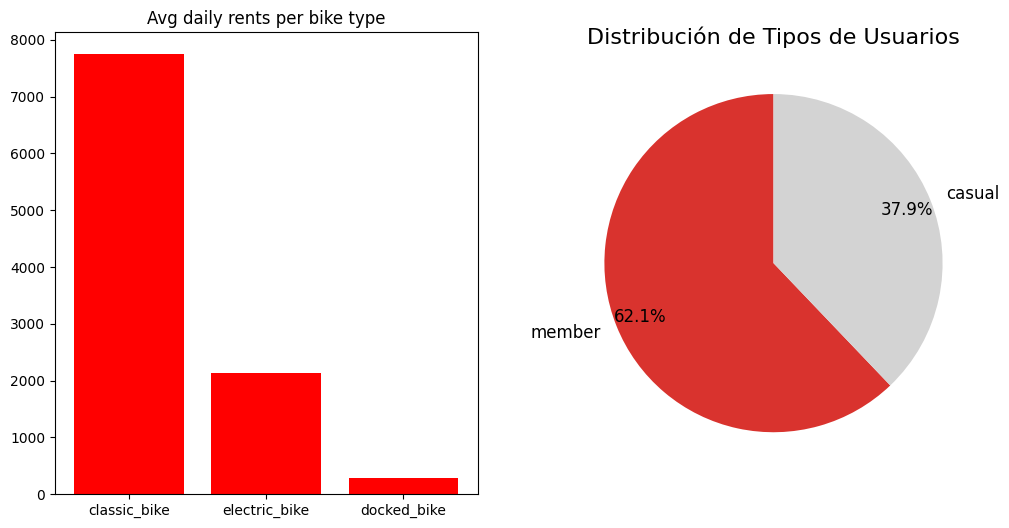

In [436]:
colors = ["#d9332e", "#d3d3d3"]
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.bar(bike_types.index, bike_types.values, color = 'red')
plt.title('Avg daily rents per bike type')

plt.subplot(1,2,2)
plt.pie(
    user_types,
    labels = user_types.index,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    colors=colors,
    textprops={'fontsize': 12}  # Ajuste del tamaño de fuente de porcentajes
)
# Título
plt.title("Distribución de Tipos de Usuarios", fontsize=16)


plt.show()


### 3.2. Análisis del clima de Washington DC

##### 3.2.1 Temperatura

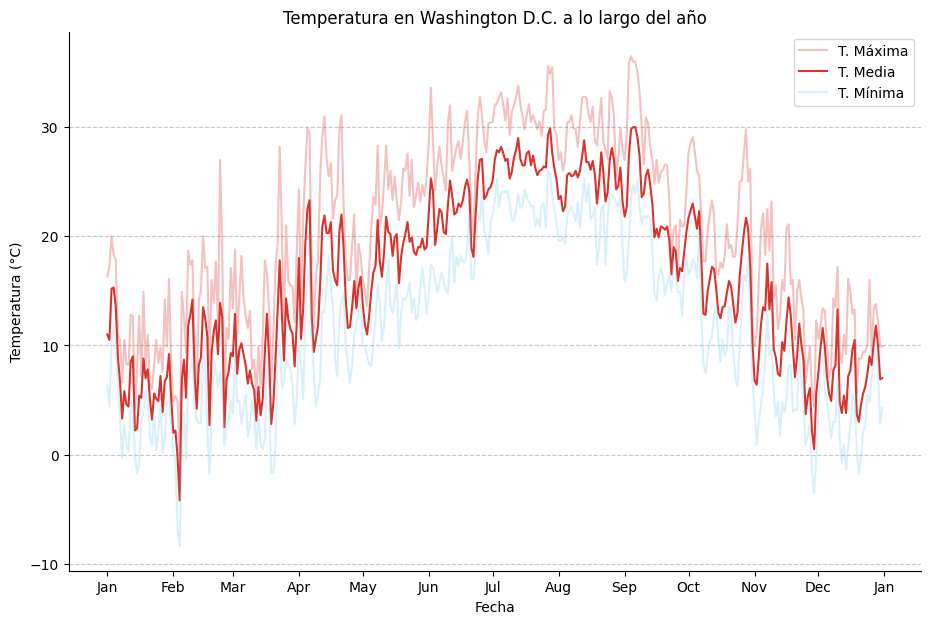

In [437]:
plt.figure(figsize = (11,7))
plt.plot(df_weather['datetime'], df_weather['tempmax'], color = '#d9332e', label = 'T. Máxima', alpha = 0.3)
plt.plot(df_weather['datetime'], df_weather['temp'], color = '#d9332e', label = 'T. Media', alpha = 1)
plt.plot(df_weather['datetime'], df_weather['tempmin'], color = 'skyblue', label = 'T. Mínima', alpha = 0.3)
plt.title('Temperatura en Washington D.C. a lo largo del año')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.legend()

# Configurar el eje x para mostrar solo los meses
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Localiza los meses
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Formato de fecha: Mes

# Ocultar el recuadro (spines)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()



##### 3.2.2.Precipitaciones

In [438]:
df_weather.head()

,datetime,name,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,precip,precipcover,snow,snowdepth,windgust,windspeed,uvindex
0,2023-01-01,"Washington,DC,USA",16.3,6.4,11.0,16.3,5.4,10.7,0.101,4.17,0.0,0.0,22.3,14.2,4
1,2023-01-02,"Washington,DC,USA",17.2,4.4,10.5,17.2,2.4,10.1,0.000,0.00,0.0,0.0,16.6,14.7,4
2,2023-01-03,"Washington,DC,USA",20.0,10.1,15.2,20.0,10.1,15.2,0.000,0.00,0.0,0.0,47.1,28.5,2
3,2023-01-04,"Washington,DC,USA",18.3,11.9,15.3,18.3,11.9,15.3,0.000,0.00,0.0,0.0,50.0,22.8,2
4,2023-01-05,"Washington,DC,USA",17.8,9.8,13.5,17.8,7.3,13.3,0.000,0.00,0.0,0.0,22.3,20.2,4


In [439]:
# Filtramos en dos tablas, una para los dias con lluvia y otra para los días sin lluvia
no_rain_days = df_weather[df_weather['precip'] == 0]
rain_days = df_weather[df_weather['precip'] != 0]

In [440]:
no_rain_days.shape[0]

224

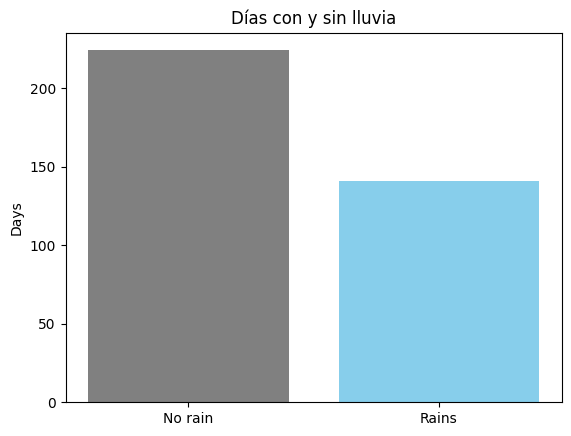

In [441]:
plt.title('Días con y sin lluvia')
plt.bar(['No rain', 'Rains'],[no_rain_days.shape[0], rain_days.shape[0]], color =['grey', 'skyblue'])
plt.ylabel('Days')
plt.show()

In [442]:
no_snow_days = df_weather[df_weather['snow'] == 0]
snow_days = df_weather[df_weather['snow'] != 0]

snow_days.shape[0]      # Solo hubo un día con nieve en ese periodo por lo que no se tendrá en cuenta en el análisis

2

##### 3.1.3. Viento

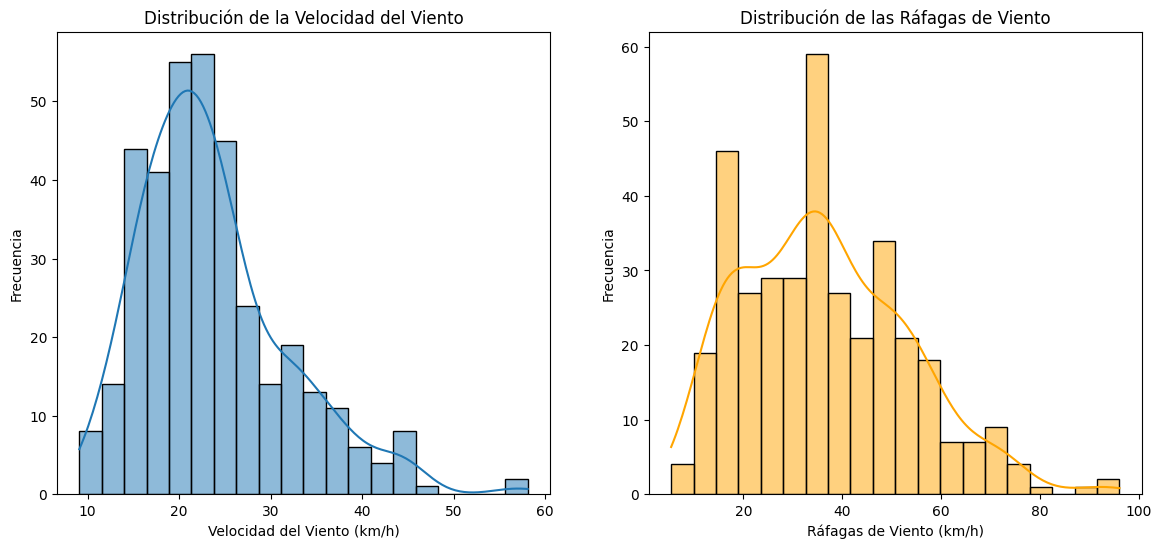

In [443]:
# Configurar el tamaño de las figuras
plt.figure(figsize=(14, 6))

# Histograma para la velocidad del viento
plt.subplot(1, 2, 1)
sns.histplot(df_weather['windspeed'], kde=True, bins=20)
plt.title('Distribución de la Velocidad del Viento')
plt.xlabel('Velocidad del Viento (km/h)')
plt.ylabel('Frecuencia')

# Histograma para las ráfagas de viento
plt.subplot(1, 2, 2)
sns.histplot(df_weather['windgust'], kde=True, bins=20, color='orange')
plt.title('Distribución de las Ráfagas de Viento')
plt.xlabel('Ráfagas de Viento (km/h)')
plt.ylabel('Frecuencia')

plt.show()

### 4. Análisis bivariante

#### 4.1. Impacto de las condiciones climáticas en el número de alquileres

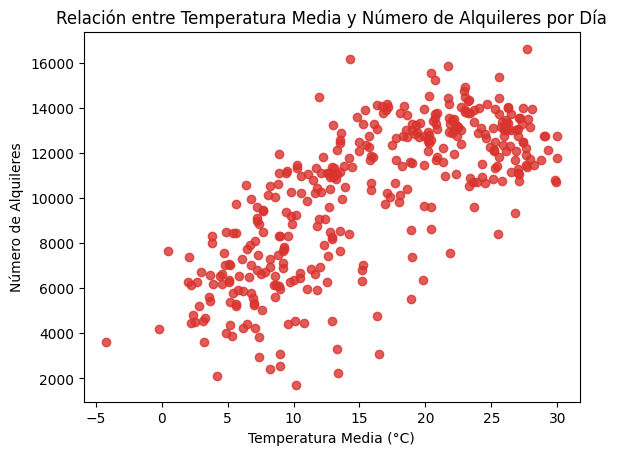

In [444]:
plt.scatter(df_weather['temp'], total_rents_per_day['pickup_counts'], alpha = 0.8, marker = 'o', color = '#d9332e')
plt.title('Relación entre Temperatura Media y Número de Alquileres por Día')
plt.xlabel('Temperatura Media (°C)')
plt.ylabel('Número de Alquileres')
plt.show()

In [445]:
df_weather['rain'] = df_weather['precip'].apply(lambda x: 'Rain' if x > 0 else 'No Rain')
df_weather.head()


,datetime,name,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,precip,precipcover,snow,snowdepth,windgust,windspeed,uvindex,rain
0,2023-01-01,"Washington,DC,USA",16.3,6.4,11.0,16.3,5.4,10.7,0.101,4.17,0.0,0.0,22.3,14.2,4,Rain
1,2023-01-02,"Washington,DC,USA",17.2,4.4,10.5,17.2,2.4,10.1,0.000,0.00,0.0,0.0,16.6,14.7,4,No Rain
2,2023-01-03,"Washington,DC,USA",20.0,10.1,15.2,20.0,10.1,15.2,0.000,0.00,0.0,0.0,47.1,28.5,2,No Rain
3,2023-01-04,"Washington,DC,USA",18.3,11.9,15.3,18.3,11.9,15.3,0.000,0.00,0.0,0.0,50.0,22.8,2,No Rain
4,2023-01-05,"Washington,DC,USA",17.8,9.8,13.5,17.8,7.3,13.3,0.000,0.00,0.0,0.0,22.3,20.2,4,No Rain


In [446]:
# Añadimos la columna rain intensity a la tabla total_rents_per_day
total_rents_per_day = pd.merge(left = total_rents_per_day, right = df_weather[['datetime','rain']],
                            left_on = total_rents_per_day.index, right_on = 'datetime', how = 'left')
total_rents_per_day.set_index('datetime', inplace = True)
total_rents_per_day

,pickup_counts,dropoff_counts,rain
datetime,,,
2023-01-01,5972.0,5899.0,Rain
2023-01-02,6462.0,6421.0,No Rain
2023-01-03,6811.0,6770.0,No Rain
2023-01-04,7005.0,6965.0,No Rain
2023-01-05,7625.0,7567.0,No Rain
...,...,...,...
2023-12-27,1708.0,1608.0,Rain
2023-12-28,5903.0,5839.0,Rain
2023-12-29,6364.0,6323.0,No Rain


/var/folders/7j/lfytp_zn1p3gd9v7k7jvgk340000gn/T/ipykernel_9428/2113565116.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = total_rents_per_day['rain'], y = total_rents_per_day['pickup_counts'], palette = ['skyblue', 'red'])


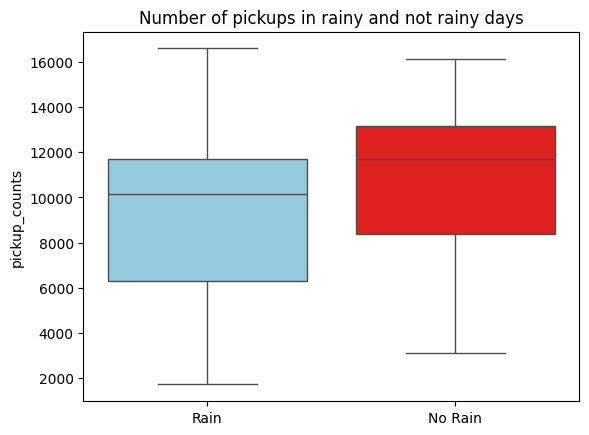

In [447]:
plt.title('Number of pickups in rainy and not rainy days')
sns.boxplot(x = total_rents_per_day['rain'], y = total_rents_per_day['pickup_counts'], palette = ['skyblue', 'red'])
plt.xlabel('')
plt.show()

In [448]:
# Añadimos una columna que clasifique las lluvias en 5 niveles de intensidad segun los mm/h que cayeron ese día
df_weather['rain_intensity'] = df_weather['precip'].map(lambda x: 'No rain' if x == 0 else          
                                                        'Light Rain'  if x < 2 else
                                                        'Moderate Rain' if x < 15 else
                                                        'Heavy Rain' if x < 30 else
                                                        'Very Heavy Rain')

# Añadimos la columna rain intensity a la tabla total_rents_per_day
total_rents_per_day = pd.merge(left = total_rents_per_day, right = df_weather[['datetime','rain_intensity']],
                            left_on = total_rents_per_day.index, right_on = 'datetime', how = 'left')
total_rents_per_day.set_index('datetime', inplace = True)
total_rents_per_day
                                                        

,pickup_counts,dropoff_counts,rain,rain_intensity
datetime,,,,
2023-01-01,5972.0,5899.0,Rain,Light Rain
2023-01-02,6462.0,6421.0,No Rain,No rain
2023-01-03,6811.0,6770.0,No Rain,No rain
2023-01-04,7005.0,6965.0,No Rain,No rain
2023-01-05,7625.0,7567.0,No Rain,No rain
...,...,...,...,...
2023-12-27,1708.0,1608.0,Rain,Heavy Rain
2023-12-28,5903.0,5839.0,Rain,Light Rain
2023-12-29,6364.0,6323.0,No Rain,No rain


/var/folders/7j/lfytp_zn1p3gd9v7k7jvgk340000gn/T/ipykernel_9428/3165136675.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = total_rents_per_day['rain_intensity'], y = total_rents_per_day['pickup_counts'], palette = [ '#fcefd4','#d3d3d3', 'skyblue', 'blue', '#0d0d31'], order = ['No rain', 'Light Rain', 'Moderate Rain', 'Heavy Rain', 'Very Heavy Rain'])


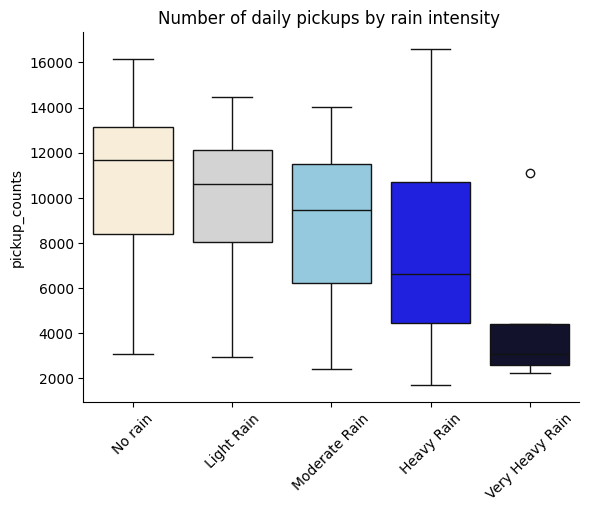

In [449]:
plt.title('Number of daily pickups by rain intensity ')
sns.boxplot(x = total_rents_per_day['rain_intensity'], y = total_rents_per_day['pickup_counts'], palette = [ '#fcefd4','#d3d3d3', 'skyblue', 'blue', '#0d0d31'], order = ['No rain', 'Light Rain', 'Moderate Rain', 'Heavy Rain', 'Very Heavy Rain'])
plt.xlabel('')
plt.xticks(rotation=45)

# eliminar el recuadro
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.show()

In [450]:
# Añadimos la columna rain intensity a la tabla total_rents_per_day
total_rents_per_day = pd.merge(left = total_rents_per_day, right = df_weather[['datetime','windspeed']],
                            left_on = total_rents_per_day.index, right_on = 'datetime', how = 'left')
total_rents_per_day.set_index('datetime', inplace = True)
total_rents_per_day

,pickup_counts,dropoff_counts,rain,rain_intensity,windspeed
datetime,,,,,
2023-01-01,5972.0,5899.0,Rain,Light Rain,14.2
2023-01-02,6462.0,6421.0,No Rain,No rain,14.7
2023-01-03,6811.0,6770.0,No Rain,No rain,28.5
2023-01-04,7005.0,6965.0,No Rain,No rain,22.8
2023-01-05,7625.0,7567.0,No Rain,No rain,20.2
...,...,...,...,...,...
2023-12-27,1708.0,1608.0,Rain,Heavy Rain,16.1
2023-12-28,5903.0,5839.0,Rain,Light Rain,16.0
2023-12-29,6364.0,6323.0,No Rain,No rain,25.9


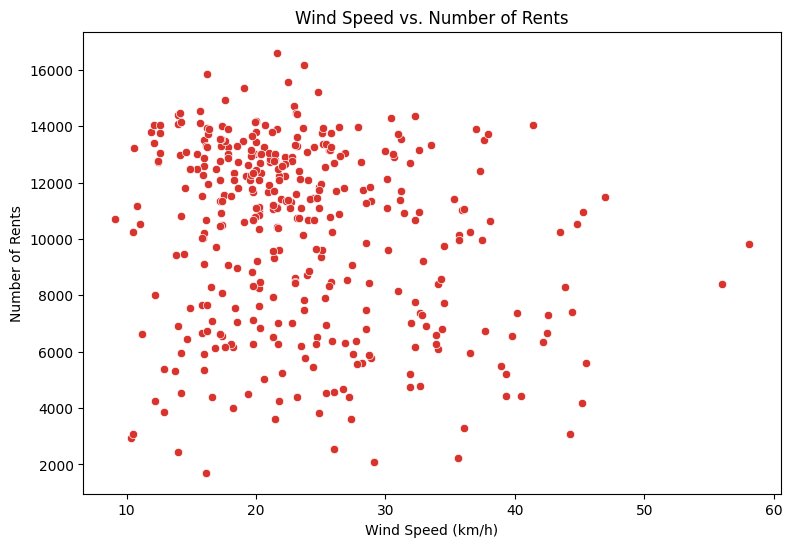

In [451]:
# Gráfico de dispersión para velocidad del viento vs. número de alquileres
plt.figure(figsize=(9, 6))
sns.scatterplot(x='windspeed', y= 'pickup_counts', data=total_rents_per_day, color = '#d9332e')
plt.title('Wind Speed vs. Number of Rents')
plt.xlabel('Wind Speed (km/h)')
plt.ylabel('Number of Rents')
plt.show()

In [452]:
# Categorizamos los tipos de viento según su velocidad en km/h
def categorize_wind(windspeed):
    if windspeed < 19:
        return 'Light Breeze'
    elif windspeed < 34:
        return 'Moderate Breeze'
    elif windspeed < 49:
        return 'Heavy Breeze'
    else: return 'Heavy wind'

total_rents_per_day['wind intensity'] = total_rents_per_day['windspeed'].apply(categorize_wind)
total_rents_per_day

,pickup_counts,dropoff_counts,rain,rain_intensity,windspeed,wind intensity
datetime,,,,,,
2023-01-01,5972.0,5899.0,Rain,Light Rain,14.2,Light Breeze
2023-01-02,6462.0,6421.0,No Rain,No rain,14.7,Light Breeze
2023-01-03,6811.0,6770.0,No Rain,No rain,28.5,Moderate Breeze
2023-01-04,7005.0,6965.0,No Rain,No rain,22.8,Moderate Breeze
2023-01-05,7625.0,7567.0,No Rain,No rain,20.2,Moderate Breeze
...,...,...,...,...,...,...
2023-12-27,1708.0,1608.0,Rain,Heavy Rain,16.1,Light Breeze
2023-12-28,5903.0,5839.0,Rain,Light Rain,16.0,Light Breeze
2023-12-29,6364.0,6323.0,No Rain,No rain,25.9,Moderate Breeze


/var/folders/7j/lfytp_zn1p3gd9v7k7jvgk340000gn/T/ipykernel_9428/1878492298.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=total_rents_per_day, x='wind intensity', y='pickup_counts', palette='viridis', estimator=np.mean)


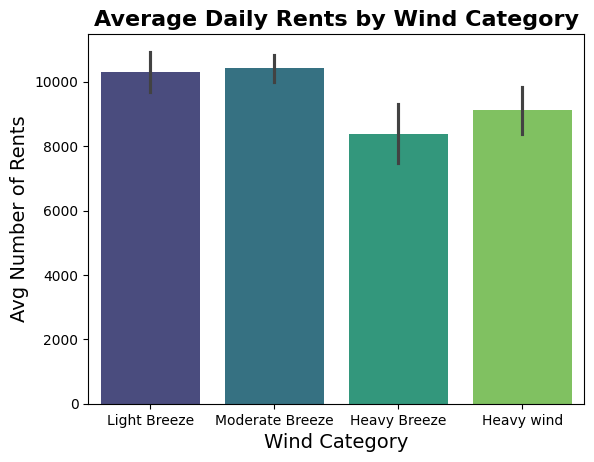

In [453]:
sns.barplot(data=total_rents_per_day, x='wind intensity', y='pickup_counts', palette='viridis', estimator=np.mean)
plt.title('Average Daily Rents by Wind Category', fontsize=16, fontweight='bold')
plt.xlabel('Wind Category', fontsize=14)
plt.ylabel('Avg Number of Rents', fontsize=14)
plt.show()

In [454]:
total_rents_per_day = pd.merge(left = total_rents_per_day, right = df_weather[['datetime','precip', 'temp', 'uvindex']],
                            left_on = total_rents_per_day.index, right_on = 'datetime', how = 'left')
total_rents_per_day.set_index('datetime', inplace = True)
total_rents_per_day

,pickup_counts,dropoff_counts,rain,rain_intensity,windspeed,wind intensity,precip,temp,uvindex
datetime,,,,,,,,,
2023-01-01,5972.0,5899.0,Rain,Light Rain,14.2,Light Breeze,0.101,11.0,4
2023-01-02,6462.0,6421.0,No Rain,No rain,14.7,Light Breeze,0.000,10.5,4
2023-01-03,6811.0,6770.0,No Rain,No rain,28.5,Moderate Breeze,0.000,15.2,2
2023-01-04,7005.0,6965.0,No Rain,No rain,22.8,Moderate Breeze,0.000,15.3,2
2023-01-05,7625.0,7567.0,No Rain,No rain,20.2,Moderate Breeze,0.000,13.5,4
...,...,...,...,...,...,...,...,...,...
2023-12-27,1708.0,1608.0,Rain,Heavy Rain,16.1,Light Breeze,26.626,10.2,1
2023-12-28,5903.0,5839.0,Rain,Light Rain,16.0,Light Breeze,1.043,11.8,2
2023-12-29,6364.0,6323.0,No Rain,No rain,25.9,Moderate Breeze,0.000,10.0,4


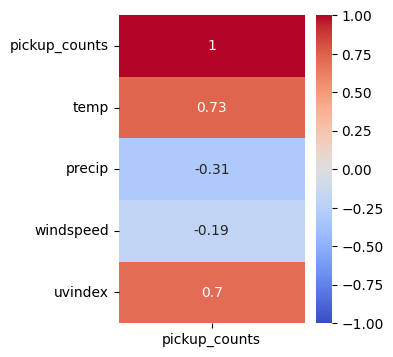

In [455]:
# Calcular la matriz de correlación con las columnas relevantes
correlation_matrix = total_rents_per_day[['pickup_counts', 'temp', 'precip', 'windspeed', 'uvindex']].corr()

plt.figure(figsize=(3, 4))
sns.heatmap(correlation_matrix[['pickup_counts']], annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
#plt.title('Correlation of Weather Variables with Rent Demand')
plt.show()


#### 4.2 Impacto del clima en el tipo de alquiler

In [456]:
df_duration = df_daily_rents.groupby('start_date')[['start_date', 'duration']].agg({
    'duration': 'mean'
}).reset_index()
df_duration.rename(columns = {'start_date': 'datetime', 'duration': 'avg_duration'}, inplace = True)
df_duration.set_index('datetime', inplace = True)
df_duration

,avg_duration
datetime,
2023-01-01,23.339108
2023-01-02,20.752203
2023-01-03,16.123602
2023-01-04,14.791589
2023-01-05,15.747237
...,...
2023-12-27,11.990525
2023-12-28,16.932291
2023-12-29,17.267287


In [457]:
# Añadimos la columna temp, precip, rain_intensity, windspeed, wind intensity a la tabla df_duration
df_duration = pd.merge(left = df_duration, right = total_rents_per_day[['temp','precip', 'rain_intensity', 'windspeed', 'wind intensity']],
                            left_index=True,  right_index=True, how = 'left')
df_duration.rename(columns = {'temp': 'avg_temp'}, inplace = True)
df_duration

,avg_duration,avg_temp,precip,rain_intensity,windspeed,wind intensity
datetime,,,,,,
2023-01-01,23.339108,11.0,0.101,Light Rain,14.2,Light Breeze
2023-01-02,20.752203,10.5,0.000,No rain,14.7,Light Breeze
2023-01-03,16.123602,15.2,0.000,No rain,28.5,Moderate Breeze
2023-01-04,14.791589,15.3,0.000,No rain,22.8,Moderate Breeze
2023-01-05,15.747237,13.5,0.000,No rain,20.2,Moderate Breeze
...,...,...,...,...,...,...
2023-12-27,11.990525,10.2,26.626,Heavy Rain,16.1,Light Breeze
2023-12-28,16.932291,11.8,1.043,Light Rain,16.0,Light Breeze
2023-12-29,17.267287,10.0,0.000,No rain,25.9,Moderate Breeze


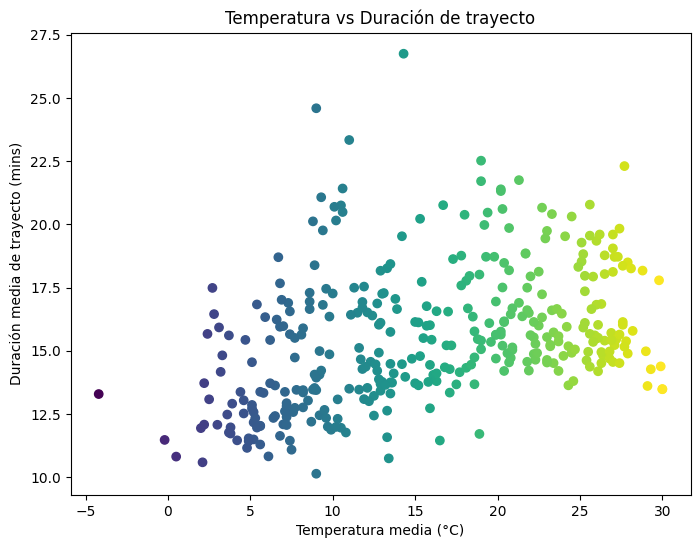

In [507]:
plt.figure(figsize=(8, 6))
plt.scatter(df_duration['avg_temp'], df_duration['avg_duration'], c=df_duration['avg_temp'], cmap='viridis')
plt.title('Temperatura vs Duración de trayecto')
plt.xlabel('Temperatura media (°C)')
plt.ylabel('Duración media de trayecto (mins)')
plt.show()

/var/folders/7j/lfytp_zn1p3gd9v7k7jvgk340000gn/T/ipykernel_9428/1192934538.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df_duration, x = 'rain_intensity', y = 'avg_duration', palette = 'Blues', order = ['No rain', 'Light Rain', 'Moderate Rain', 'Heavy Rain', 'Very Heavy Rain'])


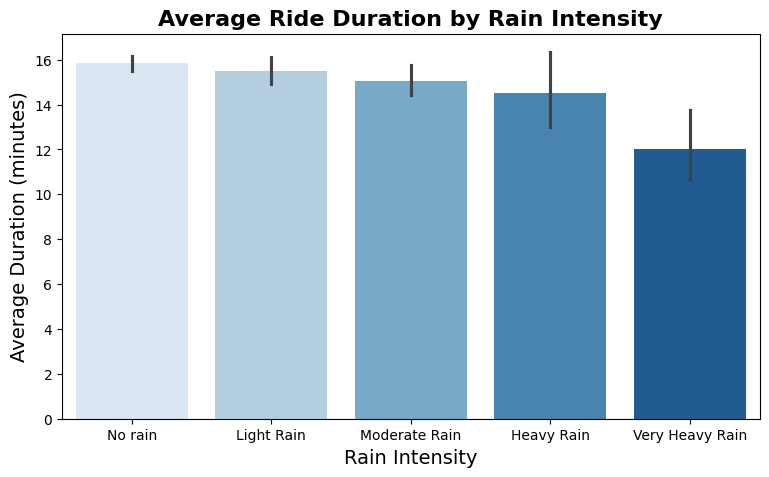

In [459]:
plt.figure(figsize=(9, 5))
sns.barplot(data = df_duration, x = 'rain_intensity', y = 'avg_duration', palette = 'Blues', order = ['No rain', 'Light Rain', 'Moderate Rain', 'Heavy Rain', 'Very Heavy Rain'])
plt.title('Average Ride Duration by Rain Intensity', fontsize=16, fontweight='bold')
plt.xlabel('Rain Intensity', fontsize=14)
plt.ylabel('Average Duration (minutes)', fontsize=14)
plt.show()

In [460]:
# Crear tabla agrupada por tipo de bicicleta y dia
df_bike_type = df_daily_rents.groupby(['start_date', 'rideable_type']).size().reset_index(name='count')
df_bike_type.rename(columns = {'rideable_type':'bike_type', 'count':'nº of rents'}, inplace = True)

# Añadimos al df la columna de intensidad de lluvia
df_bike_type = pd.merge(left = df_bike_type, right = df_weather[['datetime', 'rain']], left_on = 'start_date', right_on = 'datetime', how = 'left')
df_grouped = df_bike_type.groupby(['rain', 'bike_type'])[['rain', 'bike_type', 'nº of rents']].agg({'nº of rents':'mean'}).reset_index()
df_grouped

# Calcular el total de alquileres para cada intensidad de lluvia
total_rents_per_intensity = df_grouped.groupby('rain')['nº of rents'].transform('sum')

# Calcular el porcentaje de cada tipo de bicicleta dentro de cada intensidad de lluvia
df_grouped['percentage'] = (df_grouped['nº of rents'] / total_rents_per_intensity) * 100

# Definir el orden de las categorías para "rain intensity"
df_grouped['rain'] = pd.Categorical(
    df_grouped['rain'], 
    categories=["No Rain", "Rain"],
    ordered=True)

# ordenar el df según la intensidad de lluvia para que luego aparezca correctamente en el gráfico
df_grouped = df_grouped.sort_values('rain')

df_grouped

,rain,bike_type,nº of rents,percentage
0,No Rain,classic_bike,8227.433036,75.248966
1,No Rain,docked_bike,427.205298,3.907265
2,No Rain,electric_bike,2278.977679,20.843769
3,Rain,classic_bike,6985.007092,75.700508
4,Rain,docked_bike,352.238095,3.817405
5,Rain,electric_bike,1889.914894,20.482086


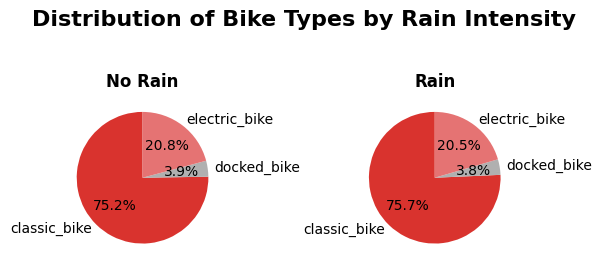

In [461]:
# Obtener las categorías únicas de intensidad de lluvia
rain_intensities = df_grouped['rain'].unique()

# Crear una figura
fig = plt.figure(figsize=(6, 3))
colors = ['#d9332e', '#b0b0b0',  '#e57373']  # Tres colores diferentes

# Iterar sobre cada categoría de intensidad de lluvia y crear un gráfico de pastel
for i, intensity in enumerate(rain_intensities, 1):  # `1` para comenzar en la posición 1
    # Filtrar los datos para la intensidad de lluvia actual
    data = df_grouped[df_grouped['rain'] == intensity]
    
    # Crear un subplot
    plt.subplot(1,2,i)
    
    # Crear el gráfico de pastel
    plt.pie(data['percentage'], labels=data['bike_type'], autopct='%1.1f%%', startangle=90, colors=colors)
    plt.title(f'{intensity}', fontsize=12, fontweight='bold')

# Título general de la figura
fig.suptitle('Distribution of Bike Types by Rain Intensity', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [462]:
# Crear tabla agrupada por tipo de bicicleta y dia
df_user = df_daily_rents.groupby(['start_date', 'member_casual']).size().reset_index(name='count')
df_user.rename(columns = {'count':'nº of rents'}, inplace = True)

# Añadimos al df la columna de intensidad de lluvia
df_user = pd.merge(left = df_user, right = df_weather[['datetime', 'rain']], left_on = 'start_date', right_on = 'datetime', how = 'left')
df_grouped = df_user.groupby(['rain', 'member_casual'])[['rain', 'member_casual', 'nº of rents']].agg({'nº of rents':'mean'}).reset_index()
df_grouped

# Calcular el total de alquileres para cada intensidad de lluvia
total_rents_per_rain = df_grouped.groupby('rain')['nº of rents'].transform('sum')

# Calcular el porcentaje de cada tipo de bicicleta dentro de cada intensidad de lluvia
df_grouped['percentage'] = (df_grouped['nº of rents'] / total_rents_per_rain) * 100

# Definir el orden de las categorías para "rain intensity"
df_grouped['rain'] = pd.Categorical(
    df_grouped['rain'], 
    categories=["No Rain", "Rain"],
    ordered=True)

# ordenar el df según la intensidad de lluvia para que luego aparezca correctamente en el gráfico
df_grouped = df_grouped.sort_values('rain')

df_grouped

,rain,member_casual,nº of rents,percentage
0,No Rain,casual,4066.741071,37.674570
1,No Rain,member,6727.651786,62.325430
2,Rain,casual,3493.347518,38.232032
3,Rain,member,5643.879433,61.767968


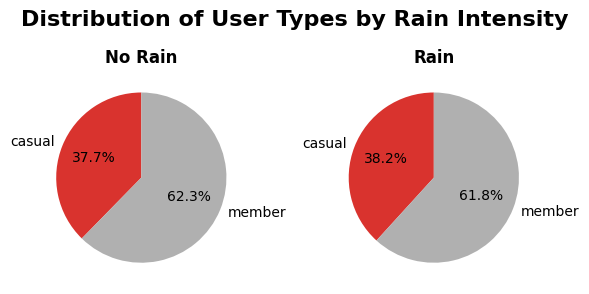

In [463]:
# Obtener las categorías únicas de intensidad de lluvia
rain_type = df_grouped['rain'].unique()

# Crear una figura
fig = plt.figure(figsize=(6, 3))
colors = ['#d9332e', '#b0b0b0']  # Tres colores diferentes

# Iterar sobre cada categoría de intensidad de lluvia y crear un gráfico de pastel
for i, type in enumerate(rain_type, 1):  # `1` para comenzar en la posición 1
    # Filtrar los datos para la intensidad de lluvia actual
    data = df_grouped[df_grouped['rain'] == type]
    
    # Crear un subplot
    plt.subplot(1,2,i)
    
    # Crear el gráfico de pastel
    plt.pie(data['percentage'], labels=data['member_casual'], autopct='%1.1f%%', startangle=90, colors=colors)
    plt.title(f'{type}', fontsize=12, fontweight='bold')

# Título general de la figura
fig.suptitle('Distribution of User Types by Rain Intensity', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

/var/folders/7j/lfytp_zn1p3gd9v7k7jvgk340000gn/T/ipykernel_9428/1005235828.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df_duration, x = 'wind intensity', y = 'avg_duration', palette = 'Reds')


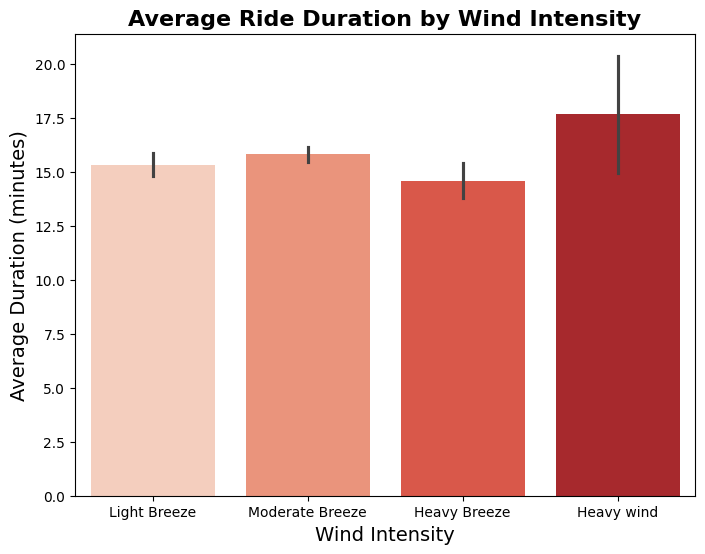

In [464]:
plt.figure(figsize=(8, 6))
sns.barplot(data = df_duration, x = 'wind intensity', y = 'avg_duration', palette = 'Reds')
plt.title('Average Ride Duration by Wind Intensity', fontsize=16, fontweight='bold')
plt.xlabel('Wind Intensity', fontsize=14)
plt.ylabel('Average Duration (minutes)', fontsize=14)
plt.show()

In [465]:
total_rents_per_day

,pickup_counts,dropoff_counts,rain,rain_intensity,windspeed,wind intensity,precip,temp,uvindex
datetime,,,,,,,,,
2023-01-01,5972.0,5899.0,Rain,Light Rain,14.2,Light Breeze,0.101,11.0,4
2023-01-02,6462.0,6421.0,No Rain,No rain,14.7,Light Breeze,0.000,10.5,4
2023-01-03,6811.0,6770.0,No Rain,No rain,28.5,Moderate Breeze,0.000,15.2,2
2023-01-04,7005.0,6965.0,No Rain,No rain,22.8,Moderate Breeze,0.000,15.3,2
2023-01-05,7625.0,7567.0,No Rain,No rain,20.2,Moderate Breeze,0.000,13.5,4
...,...,...,...,...,...,...,...,...,...
2023-12-27,1708.0,1608.0,Rain,Heavy Rain,16.1,Light Breeze,26.626,10.2,1
2023-12-28,5903.0,5839.0,Rain,Light Rain,16.0,Light Breeze,1.043,11.8,2
2023-12-29,6364.0,6323.0,No Rain,No rain,25.9,Moderate Breeze,0.000,10.0,4


In [466]:
df_duration

,avg_duration,avg_temp,precip,rain_intensity,windspeed,wind intensity
datetime,,,,,,
2023-01-01,23.339108,11.0,0.101,Light Rain,14.2,Light Breeze
2023-01-02,20.752203,10.5,0.000,No rain,14.7,Light Breeze
2023-01-03,16.123602,15.2,0.000,No rain,28.5,Moderate Breeze
2023-01-04,14.791589,15.3,0.000,No rain,22.8,Moderate Breeze
2023-01-05,15.747237,13.5,0.000,No rain,20.2,Moderate Breeze
...,...,...,...,...,...,...
2023-12-27,11.990525,10.2,26.626,Heavy Rain,16.1,Light Breeze
2023-12-28,16.932291,11.8,1.043,Light Rain,16.0,Light Breeze
2023-12-29,17.267287,10.0,0.000,No rain,25.9,Moderate Breeze


In [467]:
# Añadimos la columna avg_duration a total_rents_per-day
total_rents_per_day = pd.merge(left = total_rents_per_day, right = df_duration['avg_duration'] , left_index = True, right_index = True, how = 'inner')
total_rents_per_day

,pickup_counts,dropoff_counts,rain,rain_intensity,windspeed,wind intensity,precip,temp,uvindex,avg_duration
datetime,,,,,,,,,,
2023-01-01,5972.0,5899.0,Rain,Light Rain,14.2,Light Breeze,0.101,11.0,4,23.339108
2023-01-02,6462.0,6421.0,No Rain,No rain,14.7,Light Breeze,0.000,10.5,4,20.752203
2023-01-03,6811.0,6770.0,No Rain,No rain,28.5,Moderate Breeze,0.000,15.2,2,16.123602
2023-01-04,7005.0,6965.0,No Rain,No rain,22.8,Moderate Breeze,0.000,15.3,2,14.791589
2023-01-05,7625.0,7567.0,No Rain,No rain,20.2,Moderate Breeze,0.000,13.5,4,15.747237
...,...,...,...,...,...,...,...,...,...,...
2023-12-27,1708.0,1608.0,Rain,Heavy Rain,16.1,Light Breeze,26.626,10.2,1,11.990525
2023-12-28,5903.0,5839.0,Rain,Light Rain,16.0,Light Breeze,1.043,11.8,2,16.932291
2023-12-29,6364.0,6323.0,No Rain,No rain,25.9,Moderate Breeze,0.000,10.0,4,17.267287


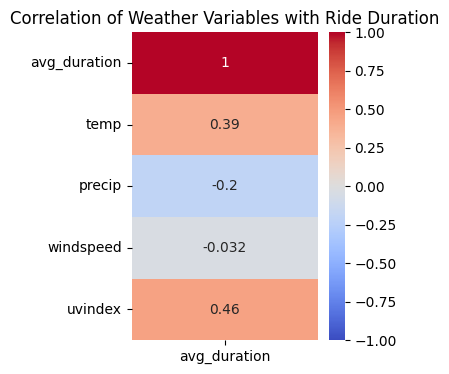

In [468]:
# Vamos a calcular la matriz de correlacion
correlation_matrix = total_rents_per_day[['avg_duration', 'temp', 'precip', 'windspeed', 'uvindex']].corr()

plt.figure(figsize=(3, 4))
sns.heatmap(correlation_matrix[['avg_duration']], annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
plt.title('Correlation of Weather Variables with Ride Duration')
plt.show()

#### 4.3. Cambios de comportamiento de los usuarios según el día de la semana

A continuación se va a analizar la variación en la cantidad de alquileres según el día de la semana

In [469]:
df_daily_rents['DoW'] = df_daily_rents['start_date'].dt.day_of_week
rents_per_DoW = df_daily_rents.groupby('DoW').size().reset_index(name = 'Nº of rents')

# Crear diccionario para que aparezca el nombre del día de la semana
day_mapping = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

# Aplicar el mapeo a la columna 'DoW' en el DataFrame
rents_per_DoW['DoW'] = rents_per_DoW['DoW'].map(day_mapping)

In [470]:
# Creamos df únicamente con fecha y dia de la semana
unique_days = pd.DataFrame(df_daily_rents['start_date'].unique(), columns=['date'])
unique_days['DoW'] = unique_days['date'].dt.dayofweek
unique_days

days_count = unique_days['DoW'].value_counts().rename_axis('DoW').reset_index(name='day_count')
# Aplicar el mapeo a la columna 'DoW' para tener los nombres en el mismo formato que rents_per_DoW
days_count['DoW'] = days_count['DoW'].map(day_mapping)

# Unir los DataFrames para obtener el conteo de días junto con el total de alquileres
rents_per_DoW = rents_per_DoW.merge(days_count, on='DoW')
rents_per_DoW['Avg rents'] = rents_per_DoW['Nº of rents'] / rents_per_DoW['day_count']
rents_per_DoW 




,DoW,Nº of rents,day_count,Avg rents
0,Monday,483320,52,9294.615385
1,Tuesday,543239,52,10446.903846
2,Wednesday,556995,52,10711.442308
3,Thursday,563093,52,10828.711538
4,Friday,513239,52,9869.980769
5,Saturday,551072,52,10597.538462
6,Sunday,495335,53,9345.943396


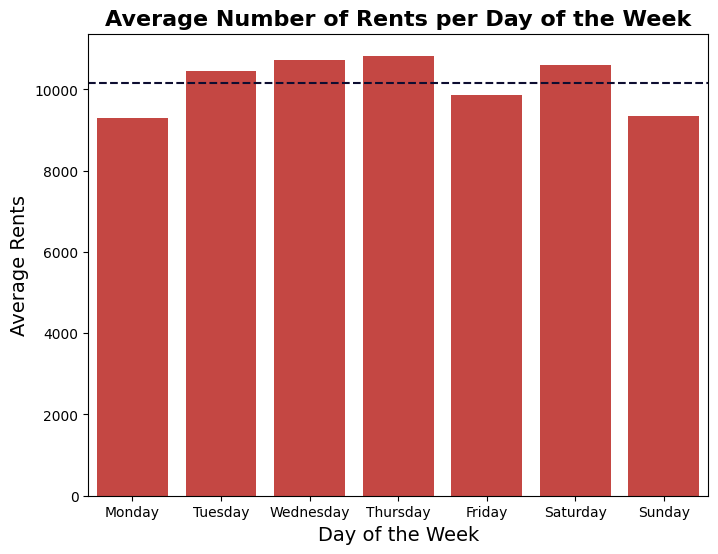

In [471]:

plt.figure(figsize = (8,6))
sns.barplot(data =rents_per_DoW, x ='DoW', y = 'Avg rents', color = '#d9332e')
plt.title('Average Number of Rents per Day of the Week', fontsize=16, fontweight='bold')
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Average Rents', fontsize=14)

# Cálculo de la media y adición de la línea en el gráfico

plt.axhline(rents_per_DoW['Avg rents'].mean(), color='#0d0d31', linestyle='--', linewidth=1.5)




plt.show()

In [472]:
# Creamos tabla de total de alquileres por dia de la semana y tipo de cliente(member or casual)
Dow_clienttype = df_daily_rents.groupby(['DoW', 'member_casual']).size().reset_index(name = 'nº of rents')
# Aplicar el mapeo a la columna 'DoW' para tener el dia de la semana en texto
Dow_clienttype['DoW'] = Dow_clienttype['DoW'].map(day_mapping)

# Calculamos la media diaria de alquileres
Dow_clienttype = Dow_clienttype.merge(days_count, on='DoW')
Dow_clienttype['Avg rents'] = Dow_clienttype['nº of rents'] / Dow_clienttype['day_count']

# Convierte rents_per_DoW en un diccionario y con un map añadir a la tabla el total de alquileres segun el dia de la semana para calcular el porcentaje de cada tipo de cliente cada dia de la semana
rents_dict = rents_per_DoW.set_index('DoW')['Nº of rents'].to_dict()
Dow_clienttype['day_total'] = Dow_clienttype['DoW'].map(rents_dict)

#Calcular el porcentaje de cada tipo de cliente cada dia
Dow_clienttype['percentage'] = (Dow_clienttype['nº of rents'] / Dow_clienttype['day_total']) * 100

Dow_clienttype['member_casual'] = pd.Categorical(Dow_clienttype['member_casual'], categories = ['member', 'casual'], ordered = True)
Dow_clienttype['DoW'] = pd.Categorical(Dow_clienttype['DoW'], categories = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered = True)
Dow_clienttype = Dow_clienttype.sort_values(['DoW', 'member_casual'])
Dow_clienttype



,DoW,member_casual,nº of rents,day_count,Avg rents,day_total,percentage
1,Monday,member,316506,52,6086.653846,483320,65.485807
0,Monday,casual,166814,52,3207.961538,483320,34.514193
3,Tuesday,member,366100,52,7040.384615,543239,67.392069
2,Tuesday,casual,177139,52,3406.519231,543239,32.607931
5,Wednesday,member,377059,52,7251.134615,556995,67.695222
4,Wednesday,casual,179936,52,3460.307692,556995,32.304778
7,Thursday,member,371140,52,7137.307692,563093,65.910960
6,Thursday,casual,191953,52,3691.403846,563093,34.089040
9,Friday,member,319048,52,6135.538462,513239,62.163631
8,Friday,casual,194191,52,3734.442308,513239,37.836369


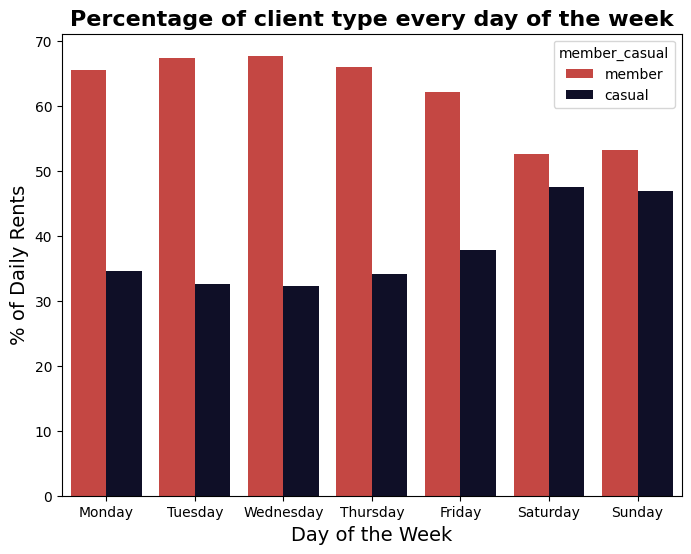

In [473]:
colors = ['#d9332e',  '#0b0b2b'] 

plt.figure(figsize = (8,6))
sns.barplot(data =Dow_clienttype, x ='DoW', y = 'percentage', hue = 'member_casual', palette = colors)
plt.title('Percentage of client type every day of the week', fontsize=16, fontweight='bold')
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('% of Daily Rents', fontsize=14)

plt.show()

In [474]:
dow_duration = df_daily_rents.groupby('DoW')[['DoW','duration']].agg({'duration':'mean'}).reset_index()
# Aplicar el mapeo a la columna 'DoW' para tener el dia de la semana en texto
dow_duration['DoW'] = dow_duration['DoW'].map(day_mapping)
dow_duration

,DoW,duration
0,Monday,15.135662
1,Tuesday,14.701269
2,Wednesday,14.571502
3,Thursday,14.876787
4,Friday,15.399038
5,Saturday,18.400421
6,Sunday,18.651275


/var/folders/7j/lfytp_zn1p3gd9v7k7jvgk340000gn/T/ipykernel_9428/1920568500.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data =dow_duration, x ='DoW', y = 'duration', palette = colors )


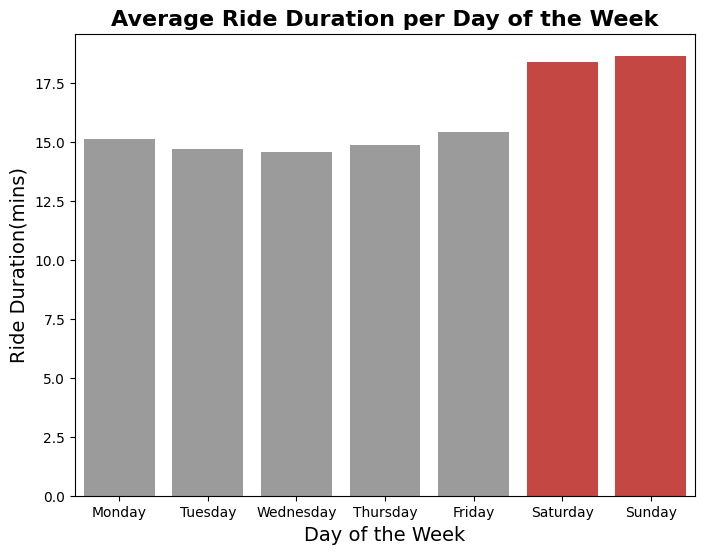

In [475]:
colors = ['#9b9b9b'] * 5 + ['#d9332e'] * 2


plt.figure(figsize = (8,6))
sns.barplot(data =dow_duration, x ='DoW', y = 'duration', palette = colors )
plt.title('Average Ride Duration per Day of the Week', fontsize=16, fontweight='bold')
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Ride Duration(mins)', fontsize=14)

plt.show()

In [476]:
df_daily_rents

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration,start_date,end_date,DoW
0,65F0ACD101BF0D49,classic_bike,2023-01-04 19:34:07,2023-01-04 19:39:29,East Falls Church Metro / Sycamore St & 19th St N,31904,W Columbia St & N Washington St,32609,38.885321,-77.156427,38.885621,-77.166917,member,5.366667,2023-01-04,2023-01-04,2
2,33E85889625FF7CA,classic_bike,2023-01-05 20:44:38,2023-01-05 20:51:18,15th & L St NW,31276,Thomas Circle,31241,38.903649,-77.034918,38.905900,-77.032500,member,6.666667,2023-01-05,2023-01-05,3
3,E1F055A1651F47A1,classic_bike,2023-01-03 17:45:14,2023-01-03 17:57:23,Hartland Rd & Harte Pl,32255,Merrifield Cinema & Merrifield Town Center,32235,38.878601,-77.222808,38.870093,-77.229970,member,12.150000,2023-01-03,2023-01-03,1
4,88CC90CEEC298BAF,classic_bike,2023-01-03 05:18:46,2023-01-03 05:25:50,Merrifield Cinema & Merrifield Town Center,32235,Hartland Rd & Harte Pl,32255,38.870093,-77.229970,38.878601,-77.222808,member,7.066667,2023-01-03,2023-01-03,1
5,3E1CDC543ED2A000,classic_bike,2023-01-11 16:55:16,2023-01-11 17:21:54,Smithsonian-National Mall / Jefferson Dr & 12t...,31248,23rd & E St NW,31260,38.888774,-77.028694,38.896104,-77.049882,casual,26.633333,2023-01-11,2023-01-11,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4467270,68A1AA2C614921C4,classic_bike,2023-12-16 00:08:39,2023-12-16 00:16:30,11th & S St NW,31280,17th & P St NW,31330,38.913601,-77.027115,38.909858,-77.038566,member,7.850000,2023-12-16,2023-12-16,5
4467271,25C0FB40A035EA7C,classic_bike,2023-12-06 18:23:32,2023-12-06 18:27:26,Eastern Market / 7th & North Carolina Ave SE,31610,Massachusetts Ave & 6th St NE,31657,38.886952,-76.996806,38.892934,-76.998273,member,3.900000,2023-12-06,2023-12-06,2
4467272,969BD21B0E2F499A,electric_bike,2023-12-09 17:47:53,2023-12-09 18:03:16,8th & D St NW,31270,16th & R St NW,31282,38.894771,-77.023308,38.912652,-77.036278,casual,15.383333,2023-12-09,2023-12-09,5
4467273,DEA9A4BA005B1A26,electric_bike,2023-12-09 18:14:52,2023-12-09 18:25:48,5th & F St NW,31620,Lincoln Rd & Seaton Pl NE/Harry Thomas Rec Center,31523,38.897282,-77.019359,38.915000,-77.007800,casual,10.933333,2023-12-09,2023-12-09,5


In [477]:
# Crear una nueva columna 'day_type' que clasifique como 'weekday' o 'weekend'
df_daily_rents['day_type'] = df_daily_rents['DoW'].apply(lambda x: 'weekend' if x >= 5 else 'weekday')

# Filtramos para obtener un df con los pickups y la info necesaria
df_pickups = df_daily_rents[['day_type','start_station_name','start_station_id','start_lat','start_lng']]
df_pickups


,day_type,start_station_name,start_station_id,start_lat,start_lng
0,weekday,East Falls Church Metro / Sycamore St & 19th St N,31904,38.885321,-77.156427
2,weekday,15th & L St NW,31276,38.903649,-77.034918
3,weekday,Hartland Rd & Harte Pl,32255,38.878601,-77.222808
4,weekday,Merrifield Cinema & Merrifield Town Center,32235,38.870093,-77.229970
5,weekday,Smithsonian-National Mall / Jefferson Dr & 12t...,31248,38.888774,-77.028694
...,...,...,...,...,...
4467270,weekend,11th & S St NW,31280,38.913601,-77.027115
4467271,weekday,Eastern Market / 7th & North Carolina Ave SE,31610,38.886952,-76.996806
4467272,weekend,8th & D St NW,31270,38.894771,-77.023308
4467273,weekend,5th & F St NW,31620,38.897282,-77.019359


In [478]:
# Filtramos y contamos los pickups por estación para weekday y weekend
weekday_pickups = df_pickups[df_pickups['day_type'] == 'weekday'].groupby(['start_station_name']).agg(
    start_lat=('start_lat', 'mean'),
    start_lng=('start_lng', 'mean'),
    pickups=('start_station_name', 'size')).reset_index()

weekend_pickups = df_pickups[df_pickups['day_type'] == 'weekend'].groupby(['start_station_name']).agg(
    start_lat=('start_lat', 'mean'),
    start_lng=('start_lng', 'mean'),
    pickups=('start_station_name', 'size')).reset_index()

weekend_pickups

,start_station_name,start_lat,start_lng,pickups
0,10th & E St NW,38.895922,-77.026043,2816
1,10th & G St NW,38.898267,-77.026257,1793
2,10th & H St NE,38.899979,-76.992713,2445
3,10th & K St NW,38.902416,-77.026228,3021
4,10th & Monroe St NE,38.932463,-76.993571,1140
...,...,...,...,...
785,Woodglen Dr & Executive Blvd,39.043173,-77.113493,254
786,Woodley Park Metro / Calvert St & Connecticut ...,38.923394,-77.051826,3163
787,Woodmont Ave & Strathmore St,38.979773,-77.093454,819
788,Woody Ward Rec Center,38.879582,-76.926610,25


In [479]:
weekend_pickups['pickups'].describe()

count      790.000000
mean      1324.565823
std       1926.353734
min          1.000000
25%         92.250000
50%        441.500000
75%       1812.250000
max      12356.000000
Name: pickups, dtype: float64

In [480]:
weekday_pickups['pickups'].describe()

count      792.000000
mean      3358.441919
std       4646.564321
min          1.000000
25%        231.750000
50%       1052.500000
75%       4972.750000
max      35034.000000
Name: pickups, dtype: float64

In [481]:
df_daily_rents

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration,start_date,end_date,DoW,day_type
0,65F0ACD101BF0D49,classic_bike,2023-01-04 19:34:07,2023-01-04 19:39:29,East Falls Church Metro / Sycamore St & 19th St N,31904,W Columbia St & N Washington St,32609,38.885321,-77.156427,38.885621,-77.166917,member,5.366667,2023-01-04,2023-01-04,2,weekday
2,33E85889625FF7CA,classic_bike,2023-01-05 20:44:38,2023-01-05 20:51:18,15th & L St NW,31276,Thomas Circle,31241,38.903649,-77.034918,38.905900,-77.032500,member,6.666667,2023-01-05,2023-01-05,3,weekday
3,E1F055A1651F47A1,classic_bike,2023-01-03 17:45:14,2023-01-03 17:57:23,Hartland Rd & Harte Pl,32255,Merrifield Cinema & Merrifield Town Center,32235,38.878601,-77.222808,38.870093,-77.229970,member,12.150000,2023-01-03,2023-01-03,1,weekday
4,88CC90CEEC298BAF,classic_bike,2023-01-03 05:18:46,2023-01-03 05:25:50,Merrifield Cinema & Merrifield Town Center,32235,Hartland Rd & Harte Pl,32255,38.870093,-77.229970,38.878601,-77.222808,member,7.066667,2023-01-03,2023-01-03,1,weekday
5,3E1CDC543ED2A000,classic_bike,2023-01-11 16:55:16,2023-01-11 17:21:54,Smithsonian-National Mall / Jefferson Dr & 12t...,31248,23rd & E St NW,31260,38.888774,-77.028694,38.896104,-77.049882,casual,26.633333,2023-01-11,2023-01-11,2,weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4467270,68A1AA2C614921C4,classic_bike,2023-12-16 00:08:39,2023-12-16 00:16:30,11th & S St NW,31280,17th & P St NW,31330,38.913601,-77.027115,38.909858,-77.038566,member,7.850000,2023-12-16,2023-12-16,5,weekend
4467271,25C0FB40A035EA7C,classic_bike,2023-12-06 18:23:32,2023-12-06 18:27:26,Eastern Market / 7th & North Carolina Ave SE,31610,Massachusetts Ave & 6th St NE,31657,38.886952,-76.996806,38.892934,-76.998273,member,3.900000,2023-12-06,2023-12-06,2,weekday
4467272,969BD21B0E2F499A,electric_bike,2023-12-09 17:47:53,2023-12-09 18:03:16,8th & D St NW,31270,16th & R St NW,31282,38.894771,-77.023308,38.912652,-77.036278,casual,15.383333,2023-12-09,2023-12-09,5,weekend
4467273,DEA9A4BA005B1A26,electric_bike,2023-12-09 18:14:52,2023-12-09 18:25:48,5th & F St NW,31620,Lincoln Rd & Seaton Pl NE/Harry Thomas Rec Center,31523,38.897282,-77.019359,38.915000,-77.007800,casual,10.933333,2023-12-09,2023-12-09,5,weekend


In [482]:
# Calculamos en el periodo cuantos días hay de fin de semana y cuantos de entre semana
date_range = pd.date_range(start=df_daily_rents['start_date'].min(), end=df_daily_rents['start_date'].max(), freq='D')
weekday_count = sum(date.weekday() < 5 for date in date_range)
weekend_count = sum(date.weekday() >= 5 for date in date_range)

print(weekday_count, weekend_count)

260 105


In [483]:
# Dividimos por el número total de días para tener la media de pickups por estación y por día
weekday_pickups['pickups'] = weekday_pickups['pickups'] / weekday_count
weekend_pickups['pickups'] = weekend_pickups['pickups'] / weekend_count

weekday_pickups.rename(columns = {'pickups': 'avg pickups'}, inplace = True)
weekend_pickups.rename(columns = {'pickups':'avg pickups'}, inplace = True)

In [484]:
# Función para crear un mapa con las estaciones y pickups
def create_map(df, title):
    mapa = folium.Map(location=[38.9072, -77.0369], zoom_start=12,          # Crea un mapa centrado en Washington, D.C.
                      tiles='CartoDB positron')                             # Usamos un estilo de mapa mínimo para dar más relevancia a los puntos)          
    marker_cluster = MarkerCluster().add_to(mapa)                           # MarkerCluster: Agrupa los marcadores cercanos en un solo marcador si están muy juntos.
    
    
    for _, row in df.iterrows():                        # Añadir marcador circular a cada estación
        folium.CircleMarker(
            location=(row['start_lat'], row['start_lng']),
            radius=row['avg pickups'] / 20,  # Ajusta el tamaño para visualizar mejor
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
            tooltip=f"{row['start_station_name']}: {row['avg pickups']} pickups"
        ).add_to(marker_cluster)
        
    folium.LayerControl().add_to(mapa)
    return mapa

# Crear mapas para weekday y weekend
weekday_map = create_map(weekday_pickups, "Weekday Pickups")
weekend_map = create_map(weekend_pickups, "Weekend Pickups")

In [485]:
weekday_map

In [486]:
# Función para crear un mapa de calor 
def create_heat_map(data, title, gradient):
    # Crear el mapa base centrado en Washington
    mapa = folium.Map(location=[38.9072, -77.0369], zoom_start=12.2, tiles='CartoDB positron')
    
    # Crear y añadir el HeatMap al mapa
    HeatMap(
        data,
        radius=18,           # Aumenta el radio para resaltar mejor las zonas de densidad
        blur=18,             # Aumenta el difuminado para una transición más suave
        max_zoom=1,          # Máximo nivel de zoom para ver el mapa de calor
        min_opacity=0.2,         # Opacidad mínima para ver áreas de baja densidad
        max_val=1.0,             # Intensidad máxima ajustada
        gradient=gradient    # Aplicar un gradiente personalizado para el color
    ).add_to(mapa)

    # Añadir leyenda al mapa usando HTML y CSS
    legend_html = '''
     <div style="
     position: fixed; 
     bottom: 50px; left: 50px; width: 170px; height: 200px; 
     background-color: white; z-index:9999; font-size:14px;
     border:2px solid grey; border-radius:10px; padding: 10px;">
     &nbsp; <b>Density Legend</b><br>
     &nbsp; <i style="background:royalblue; width: 18px; height: 18px; display: inline-block;"></i>&nbsp; Very Low<br>
     &nbsp; <i style="background:cyan; width: 18px; height: 18px; display: inline-block;"></i>&nbsp; Low<br>
     &nbsp; <i style="background:lime; width: 18px; height: 18px; display: inline-block;"></i>&nbsp; Low-Medium<br>
     &nbsp; <i style="background:yellow; width: 18px; height: 18px; display: inline-block;"></i>&nbsp; Medium<br>
     &nbsp; <i style="background:orange; width: 18px; height: 18px; display: inline-block;"></i>&nbsp; High<br>
     &nbsp; <i style="background:red; width: 18px; height: 18px; display: inline-block;"></i>&nbsp; Very High<br>
     &nbsp; <i style="background:darkred; width: 18px; height: 18px; display: inline-block;"></i>&nbsp; Maximum<br>
     </div>
     '''
    mapa.get_root().html.add_child(folium.Element(legend_html))
    
    return mapa

# Datos para el mapa de calor de días de semana
weekday_heat_data = weekday_pickups[['start_lat', 'start_lng', 'avg pickups']].values.tolist()
weekday_gradient = {0.2: 'royalblue', 0.3:'cyan', 0.4: 'lime', 0.55: 'yellow',0.70: 'orange', 0.85: 'red', 1.0: 'darkred'}
weekday_map = create_heat_map(weekday_heat_data, "Weekday Pickups Heatmap", weekday_gradient)

# Datos para el mapa de calor de fin de semana
weekend_heat_data = weekend_pickups[['start_lat', 'start_lng', 'avg pickups']].values.tolist()
weekend_gradient = {0.2: 'royalblue', 0.3:'cyan', 0.4: 'lime', 0.55: 'yellow',0.70: 'orange', 0.85: 'red', 1.0: 'darkred'}
weekend_map = create_heat_map(weekend_heat_data, "Weekend Pickups Heatmap", weekend_gradient)

/var/folders/7j/lfytp_zn1p3gd9v7k7jvgk340000gn/T/ipykernel_9428/1371228364.py:7: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(
/var/folders/7j/lfytp_zn1p3gd9v7k7jvgk340000gn/T/ipykernel_9428/1371228364.py:7: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(


In [504]:
# Mapa de calor para pickups los días entre semana
weekday_map

In [505]:
# Mapa de calor para pickups los fines de semana
weekend_map

In [489]:
# Filtramos y contamos los pickups por estación para miembros y usuarios casuales
member_pickups = df_daily_rents[df_daily_rents['member_casual'] == 'member'].groupby(['start_station_name']).agg(
    start_lat=('start_lat', 'mean'),
    start_lng=('start_lng', 'mean'),
    pickups=('start_station_name', 'size')).reset_index()

casual_pickups = df_daily_rents[df_daily_rents['member_casual'] ==  'casual'].groupby(['start_station_name']).agg(
    start_lat=('start_lat', 'mean'),
    start_lng=('start_lng', 'mean'),
    pickups=('start_station_name', 'size')).reset_index()

casual_pickups

,start_station_name,start_lat,start_lng,pickups
0,10th & E St NW,38.895921,-77.026040,5323
1,10th & G St NW,38.898267,-77.026247,2750
2,10th & H St NE,38.899977,-76.992720,2494
3,10th & K St NW,38.902413,-77.026227,5221
4,10th & Monroe St NE,38.932459,-76.993582,1369
...,...,...,...,...
782,Woodglen Dr & Executive Blvd,39.043204,-77.113493,432
783,Woodley Park Metro / Calvert St & Connecticut ...,38.923394,-77.051815,4111
784,Woodmont Ave & Strathmore St,38.979869,-77.093508,1209
785,Woody Ward Rec Center,38.879581,-76.926613,20


In [490]:
# Datos para el mapa de calor de miembros
member_heat_data = member_pickups[['start_lat', 'start_lng', 'pickups']].values.tolist()
member_gradient = {0.2: 'royalblue', 0.3:'cyan', 0.4: 'lime', 0.55: 'yellow',0.70: 'orange', 0.85: 'red', 1.0: 'darkred'}
member_map = create_heat_map(member_heat_data, "Weekday Pickups Heatmap", member_gradient)

# Datos para el mapa de calor usuarios casuales
casual_heat_data = weekend_pickups[['start_lat', 'start_lng', 'avg pickups']].values.tolist()
casual_gradient = {0.2: 'royalblue', 0.3:'cyan', 0.4: 'lime', 0.55: 'yellow',0.70: 'orange', 0.85: 'red', 1.0: 'darkred'}
casual_map = create_heat_map(casual_heat_data, "Weekend Pickups Heatmap", casual_gradient)

/var/folders/7j/lfytp_zn1p3gd9v7k7jvgk340000gn/T/ipykernel_9428/1371228364.py:7: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(
/var/folders/7j/lfytp_zn1p3gd9v7k7jvgk340000gn/T/ipykernel_9428/1371228364.py:7: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(


In [491]:
member_map

In [492]:
casual_map

In [497]:
# Calcular las coordenadas promedio de inicio y fin, y contar el número de viajes para usuarios 'member'
member_rides = df_daily_rents[df_daily_rents['member_casual'] == 'member'].groupby(
    ['start_station_name', 'end_station_name']
).agg(
    start_lat=('start_lat', 'mean'),
    start_lng=('start_lng', 'mean'),
    end_lat=('end_lat', 'mean'),
    end_lng=('end_lng', 'mean'),
    rides=('start_station_name', 'size')
).reset_index()

# Calcular las coordenadas promedio de inicio y fin, y contar el número de viajes para usuarios 'casual'
casual_rides = df_daily_rents[df_daily_rents['member_casual'] == 'casual'].groupby(
    ['start_station_name', 'end_station_name']
).agg(
    start_lat=('start_lat', 'mean'),
    start_lng=('start_lng', 'mean'),
    end_lat=('end_lat', 'mean'),
    end_lng=('end_lng', 'mean'),
    rides=('start_station_name', 'size')
).reset_index()

# Seleccionar las 500 rutas más populares para 'member' y 'casual'
top_300_member_rides = member_rides.sort_values(by='rides', ascending=False).head(300)
top_300_casual_rides = casual_rides.sort_values(by='rides', ascending=False).head(300)

# Crear y visualizar mapas separados para 'member' y 'casual' usando las coordenadas promedio de las 200 rutas más populares
for user_type, rides_data, color in [('Member', top_300_member_rides, '#d9332e'), ('Casual', top_300_casual_rides, '#225b91')]:
    # Crear el mapa centrado
    mapa = folium.Map(location=[38.89, -77.04], zoom_start=13.4)

    # Dibujar una sola línea promedio para cada par de estaciones, ajustando el grosor según la cantidad de viajes
    for _, row in rides_data.iterrows():
        folium.PolyLine(
            locations=[(row['start_lat'], row['start_lng']), (row['end_lat'], row['end_lng'])],
            color=color,
            weight=min(1 + row['rides'] / 100, 7),  # Ajuste del grosor basado en la cantidad de viajes
            opacity=0.6,
            tooltip=f"{row['start_station_name']} to {row['end_station_name']}: {row['rides']} trips"
        ).add_to(mapa)

    # Guardar o mostrar el mapa
    display_text = f"Mapa de las 300 rutas más populares para usuarios {user_type}"
    print(display_text)
    display(mapa)


Mapa de las 300 rutas más populares para usuarios Member


Mapa de las 300 rutas más populares para usuarios Casual
